In [84]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sml
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import datetime
import shap

/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# get full data set 

# inflation (2011 - Mar 2025)
inflation_data = pd.read_csv('./yoy_inflation_till_March_2025.csv')
inflation_data.head()

,Month,Year-on-Year Change (%)
0,Jan '11,12.079665
1,Feb '11,11.099837
2,Mar '11,12.779128
3,Apr '11,11.291282
4,May '11,12.352128


In [18]:
# Convert string to datetime and then format
def format_date(date_str):
    date_obj = datetime.datetime.strptime(date_str, '%Y-%m')
    return date_obj.strftime('%b \'%y')

In [20]:
# get rescaled trends dataset
full_trends_data = pd.read_csv('./rescaled_combined_trends_data_2011_2025.csv')
# Apply to your dataframe's Month column
full_trends_data['Month'] = full_trends_data['Month'].apply(format_date)
full_trends_data.tail()

,Month,Leisure,Liquid,Rent,Price,Kerosene heater,Public health,Mixture,Gas cylinder,Filling station,...,Cost of living,Samsung,cheap,Health insurance,Tuition payments,Shoes,Budget,Mental health,Soup,Emergency telephone number
166,Nov '24,29.0,72.0,75.0,96.0,0.0,50.0,72.0,68.6,68.0,...,52.0,94.6,46.0,9.0,90.0,65.0,24.9,59.0,70.0,51.0
167,Dec '24,15.0,58.0,75.0,93.0,0.0,41.0,49.0,63.0,72.0,...,44.0,99.8,48.0,8.0,74.5,71.0,27.8,48.0,56.0,50.0
168,Jan '25,31.0,74.0,84.0,91.0,36.0,52.0,71.0,112.5,76.0,...,54.0,104.0,49.0,9.0,111.1,58.0,26.8,57.0,58.0,62.0
169,Feb '25,27.0,76.0,78.0,93.0,37.0,56.0,71.0,77.6,81.0,...,58.0,92.5,56.0,8.0,93.4,60.0,26.8,59.0,59.0,63.0
170,Mar '25,22.0,91.0,82.0,93.0,0.0,46.0,68.0,76.5,86.0,...,60.0,101.9,54.0,9.0,64.5,63.0,24.9,55.0,59.0,59.0


In [45]:
# six lags of the inflation data using df.shift
inflation_data['Lag_1'] = inflation_data['Year-on-Year Change (%)'].shift(1)
inflation_data['Lag_2'] = inflation_data['Year-on-Year Change (%)'].shift(2)
inflation_data['Lag_3'] = inflation_data['Year-on-Year Change (%)'].shift(3)
inflation_data['Lag_4'] = inflation_data['Year-on-Year Change (%)'].shift(4)
inflation_data['Lag_5'] = inflation_data['Year-on-Year Change (%)'].shift(5)
inflation_data['Lag_6'] = inflation_data['Year-on-Year Change (%)'].shift(6)
inflation_data['Lag_7'] = inflation_data['Year-on-Year Change (%)'].shift(7)
inflation_data['Lag_8'] = inflation_data['Year-on-Year Change (%)'].shift(8)
inflation_data['Lag_9'] = inflation_data['Year-on-Year Change (%)'].shift(9)
inflation_data['Lag_10'] = inflation_data['Year-on-Year Change (%)'].shift(10)
inflation_data['Lag_11'] = inflation_data['Year-on-Year Change (%)'].shift(11)
inflation_data['Lag_12'] = inflation_data['Year-on-Year Change (%)'].shift(12)

# display the first few rows of the modified DataFrame
inflation_data.tail()

,Month,Year-on-Year Change (%),Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12
166,Nov '24,34.598334,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.921790,28.200174
167,Dec '24,34.796057,34.598334,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.921790
168,Jan '25,28.871419,34.796057,34.598334,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059
169,Feb '25,27.941947,28.871419,34.796057,34.598334,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232
170,Mar '25,27.018329,27.941947,28.871419,34.796057,34.598334,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433


In [46]:
# merge the two dataframes on the Month column
merged_data = pd.merge(full_trends_data, inflation_data, on='Month', how='left')
# display the first few rows of the merged DataFrame
merged_data.tail()

,Month,Leisure,Liquid,Rent,Price,Kerosene heater,Public health,Mixture,Gas cylinder,Filling station,...,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12
166,Nov '24,29.0,72.0,75.0,96.0,0.0,50.0,72.0,68.6,68.0,...,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.921790,28.200174
167,Dec '24,15.0,58.0,75.0,93.0,0.0,41.0,49.0,63.0,72.0,...,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.921790
168,Jan '25,31.0,74.0,84.0,91.0,36.0,52.0,71.0,112.5,76.0,...,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059
169,Feb '25,27.0,76.0,78.0,93.0,37.0,56.0,71.0,77.6,81.0,...,34.598334,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232
170,Mar '25,22.0,91.0,82.0,93.0,0.0,46.0,68.0,76.5,86.0,...,34.796057,34.598334,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433


In [47]:
# recorder the merged data
corr_lag_order = ['Month', 'Rice', 'Filling station', 'Gas cylinder', 'Textile', 'iPhone', 
'Meter', 'Food', 'Mental health', 'Water', 'Cylinder', 'Price', 'Code', 'Jollof rice', 
'Liter', 'Pressure', 'Oil', 'Emergency telephone number', 'Drug', 'Fee', 'Gambling', 
'Mixture', 'Gas stove', 'Food prices', 'Soup', 'Kitchen stove', 'Passport', 'Cooking', 
'Stove', 'Charcoal', 'Rate', 'Liquid', 'State', 'Cost of living', 'Nigerian cuisine', 
'Gas', 'Personal identification number', 'Savings', 'Cost', 'Outdoor recreation', 
'Electricity', 'Clothing', 'Leisure', 'Pump', 'Kerosene heater', 'Rent', 'Health', 
'Goods', 'School', 'Infinix', 'Inflation rate', 'Health care', 'Temperature', 'Refurbishment', 
'Fried rice', 'Investment', 'Petroleum industry', 'Flight', 'Data', 'Gasoline', 'Cook', 
'Footwear', 'Abuja', 'Bharti Airtel', 'Electricity meter', 'Emergency contraception', 
'used', 'Hyperinflation', 'Credit', 'Public health', 'Recreation', 'Emergency', 'Kerosene', 
'Health education', 'Fuel', 'Dance', 'Wealth', 'Business', 'Samsung', 'Sports betting', 
'Printing', 'Fare', 'MTN Group', 'Tecno', 'Lagos', 'China', 'Inflation', 'Globacom Limited', 
'cheap', 'Airplane', 'Deflation', 'Borehole', 'State of emergency', 'Used good', 
'Drinking water', 'Rechargeable calling card', 'Tuition payments', 'Do it yourself', 
'Made In China', 'Technology', 'Diesel fuel', 'Emergency management', 'Budget', 'Shoes', 
'Car', 'Economy', 'Immigration', 'University', 'Import', 'Health insurance', 'Ideal gas law', 
'Management', 'Industry', 'Unemployment', 'Natural environment', 'Monetary policy', 
'Samsung Galaxy', 'Policy', 'Drill', 'Economics', 'Petroleum', 'Data plan', 'Toyota', 
'Tourism', 'Recipe', 'Natural gas', 'Emirates Telecom', 'Lag_1', 'Lag_2', 'Lag_3', 
'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12',
'Year-on-Year Change (%)']

merged_data = merged_data[corr_lag_order]
# save the merged data
merged_data.to_csv('./merged_trends_inflation_data.csv', index=False)
# display the first few rows of the merged DataFrame

# Ensure Month is in datetime format
merged_data['Month'] = pd.to_datetime(merged_data['Month'], format='%b \'%y')

merged_data.tail()


,Month,Rice,Filling station,Gas cylinder,Textile,iPhone,Meter,Food,Mental health,Water,...,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Year-on-Year Change (%)
166,2024-11-01,38.0,68.0,68.6,81.0,82.0,75.0,76.0,59.0,74.0,...,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.921790,28.200174,34.598334
167,2024-12-01,48.0,72.0,63.0,79.0,82.0,66.0,63.0,48.0,62.0,...,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.921790,34.796057
168,2025-01-01,35.0,76.0,112.5,66.0,87.0,64.0,75.0,57.0,73.0,...,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.871419
169,2025-02-01,34.0,81.0,77.6,62.0,82.0,69.0,76.0,59.0,80.0,...,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,27.941947
170,2025-03-01,38.0,86.0,76.5,71.0,88.0,69.0,77.0,55.0,81.0,...,34.598334,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,27.018329


## Baseline Model

In [48]:
# get lagged inflation and inflation rate
lagged_df = merged_data[['Month', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6',  'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 'Year-on-Year Change (%)']]
lagged_df = lagged_df.rename(columns={'Year-on-Year Change (%)': 'Inflation rate'})
# display the first few rows of the lagged DataFrame
lagged_df.tail()

,Month,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Inflation rate
166,2024-11-01,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.921790,28.200174,34.598334
167,2024-12-01,34.598334,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.921790,34.796057
168,2025-01-01,34.796057,34.598334,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.871419
169,2025-02-01,28.871419,34.796057,34.598334,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,27.941947
170,2025-03-01,27.941947,28.871419,34.796057,34.598334,33.876872,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,27.018329


In [49]:
# split the data into train and test sets

split_date = '2024-01-01'  # Define the split date

train_data = lagged_df[lagged_df['Month'] < split_date]
test_data = lagged_df[lagged_df['Month'] >= split_date]
# display the first few rows of the train and test DataFrames
display(train_data)
display(test_data)

# print the shape of the train and test data
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

,Month,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Inflation rate
0,2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.079665
1,2011-02-01,12.079665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.099837
2,2011-03-01,11.099837,12.079665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.779128
3,2011-04-01,12.779128,11.099837,12.079665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.291282
4,2011-05-01,11.291282,12.779128,11.099837,12.079665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.352128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2023-08-01,24.079555,22.789489,22.413410,22.222247,22.043274,21.909733,21.816325,21.343795,21.465639,21.087115,20.773688,20.524842,25.797840
152,2023-09-01,25.797840,24.079555,22.789489,22.413410,22.222247,22.043274,21.909733,21.816325,21.343795,21.465639,21.087115,20.773688,26.715832
153,2023-10-01,26.715832,25.797840,24.079555,22.789489,22.413410,22.222247,22.043274,21.909733,21.816325,21.343795,21.465639,21.087115,27.329722
154,2023-11-01,27.329722,26.715832,25.797840,24.079555,22.789489,22.413410,22.222247,22.043274,21.909733,21.816325,21.343795,21.465639,28.200174


,Month,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Inflation rate
156,2024-01-01,28.921790,28.200174,27.329722,26.715832,25.797840,24.079555,22.789489,22.413410,22.222247,22.043274,21.909733,21.816325,29.899059
157,2024-02-01,29.899059,28.921790,28.200174,27.329722,26.715832,25.797840,24.079555,22.789489,22.413410,22.222247,22.043274,21.909733,31.698232
158,2024-03-01,31.698232,29.899059,28.921790,28.200174,27.329722,26.715832,25.797840,24.079555,22.789489,22.413410,22.222247,22.043274,33.201433
159,2024-04-01,33.201433,31.698232,29.899059,28.921790,28.200174,27.329722,26.715832,25.797840,24.079555,22.789489,22.413410,22.222247,33.694665
160,2024-05-01,33.694665,33.201433,31.698232,29.899059,28.921790,28.200174,27.329722,26.715832,25.797840,24.079555,22.789489,22.413410,33.953014
161,2024-06-01,33.953014,33.694665,33.201433,31.698232,29.899059,28.921790,28.200174,27.329722,26.715832,25.797840,24.079555,22.789489,34.191672
162,2024-07-01,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.921790,28.200174,27.329722,26.715832,25.797840,24.079555,33.395252
163,2024-08-01,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.921790,28.200174,27.329722,26.715832,25.797840,32.150132
164,2024-09-01,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.921790,28.200174,27.329722,26.715832,32.696276
165,2024-10-01,32.696276,32.150132,33.395252,34.191672,33.953014,33.694665,33.201433,31.698232,29.899059,28.921790,28.200174,27.329722,33.876872


Train data shape: (156, 14)
Test data shape: (15, 14)


In [50]:
# Get X-train for 1 - 12 lags
X_train_1 = train_data[['Lag_1']].dropna()
X_train_2 = train_data[['Lag_1', 'Lag_2']].dropna()
X_train_3 = train_data[['Lag_1', 'Lag_2', 'Lag_3']].dropna()
X_train_4 = train_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4']].dropna()
X_train_5 = train_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']].dropna()
X_train_6 = train_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6']].dropna()
X_train_7 = train_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7']].dropna()
X_train_8 = train_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8']].dropna()
X_train_9 = train_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9']].dropna()
X_train_10 = train_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10']].dropna()
X_train_11 = train_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11']].dropna()
X_train_12 = train_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12']].dropna()

# print the shape of the X-train data
print(f"X_train_1 shape: {X_train_1.shape}")
print(f"X_train_2 shape: {X_train_2.shape}")
print(f"X_train_3 shape: {X_train_3.shape}")
print(f"X_train_4 shape: {X_train_4.shape}")
print(f"X_train_5 shape: {X_train_5.shape}")
print(f"X_train_6 shape: {X_train_6.shape}")
print(f"X_train_7 shape: {X_train_7.shape}")
print(f"X_train_8 shape: {X_train_8.shape}")
print(f"X_train_9 shape: {X_train_9.shape}")
print(f"X_train_10 shape: {X_train_10.shape}")
print(f"X_train_11 shape: {X_train_11.shape}")
print(f"X_train_12 shape: {X_train_12.shape}")

# Get y-train for 1 - 12 lags
y_train_1 = train_data['Inflation rate'].iloc[X_train_1.index]
y_train_2 = train_data['Inflation rate'].iloc[X_train_2.index]
y_train_3 = train_data['Inflation rate'].iloc[X_train_3.index]
y_train_4 = train_data['Inflation rate'].iloc[X_train_4.index]
y_train_5 = train_data['Inflation rate'].iloc[X_train_5.index]
y_train_6 = train_data['Inflation rate'].iloc[X_train_6.index]
y_train_7 = train_data['Inflation rate'].iloc[X_train_7.index]
y_train_8 = train_data['Inflation rate'].iloc[X_train_8.index]
y_train_9 = train_data['Inflation rate'].iloc[X_train_9.index]
y_train_10 = train_data['Inflation rate'].iloc[X_train_10.index]
y_train_11 = train_data['Inflation rate'].iloc[X_train_11.index]
y_train_12 = train_data['Inflation rate'].iloc[X_train_12.index]

# print the shape of the y-train data
print(f"y_train_1 shape: {y_train_1.shape}")
print(f"y_train_2 shape: {y_train_2.shape}")
print(f"y_train_3 shape: {y_train_3.shape}")
print(f"y_train_4 shape: {y_train_4.shape}")
print(f"y_train_5 shape: {y_train_5.shape}")
print(f"y_train_6 shape: {y_train_6.shape}")
print(f"y_train_7 shape: {y_train_7.shape}")
print(f"y_train_8 shape: {y_train_8.shape}")
print(f"y_train_9 shape: {y_train_9.shape}")
print(f"y_train_10 shape: {y_train_10.shape}")
print(f"y_train_11 shape: {y_train_11.shape}")
print(f"y_train_12 shape: {y_train_12.shape}")


# Get X-test  
X_test_1 = test_data[['Lag_1']]
X_test_2 = test_data[['Lag_1', 'Lag_2']]
X_test_3 = test_data[['Lag_1', 'Lag_2', 'Lag_3']]
X_test_4 = test_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4']]
X_test_5 = test_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']]
X_test_6 = test_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6']]
X_test_7 = test_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7']]
X_test_8 = test_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8']]
X_test_9 = test_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9']]
X_test_10 = test_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10']]
X_test_11 = test_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11']]
X_test_12 = test_data[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12']]

# print the shape of the X-test data
print(f"X_test_1 shape: {X_test_1.shape}")
print(f"X_test_2 shape: {X_test_2.shape}")
print(f"X_test_3 shape: {X_test_3.shape}")
print(f"X_test_4 shape: {X_test_4.shape}")
print(f"X_test_5 shape: {X_test_5.shape}")
print(f"X_test_6 shape: {X_test_6.shape}")
print(f"X_test_7 shape: {X_test_7.shape}")
print(f"X_test_8 shape: {X_test_8.shape}")
print(f"X_test_9 shape: {X_test_9.shape}")
print(f"X_test_10 shape: {X_test_10.shape}")
print(f"X_test_11 shape: {X_test_11.shape}")
print(f"X_test_12 shape: {X_test_12.shape}")

# Get y-test
y_test = test_data['Inflation rate']

# print the shape of the y-test data
print(f"y_test shape: {y_test.shape}")

X_train_1 shape: (155, 1)
X_train_2 shape: (154, 2)
X_train_3 shape: (153, 3)
X_train_4 shape: (152, 4)
X_train_5 shape: (151, 5)
X_train_6 shape: (150, 6)
X_train_7 shape: (149, 7)
X_train_8 shape: (148, 8)
X_train_9 shape: (147, 9)
X_train_10 shape: (146, 10)
X_train_11 shape: (145, 11)
X_train_12 shape: (144, 12)
y_train_1 shape: (155,)
y_train_2 shape: (154,)
y_train_3 shape: (153,)
y_train_4 shape: (152,)
y_train_5 shape: (151,)
y_train_6 shape: (150,)
y_train_7 shape: (149,)
y_train_8 shape: (148,)
y_train_9 shape: (147,)
y_train_10 shape: (146,)
y_train_11 shape: (145,)
y_train_12 shape: (144,)
X_test_1 shape: (15, 1)
X_test_2 shape: (15, 2)
X_test_3 shape: (15, 3)
X_test_4 shape: (15, 4)
X_test_5 shape: (15, 5)
X_test_6 shape: (15, 6)
X_test_7 shape: (15, 7)
X_test_8 shape: (15, 8)
X_test_9 shape: (15, 9)
X_test_10 shape: (15, 10)
X_test_11 shape: (15, 11)
X_test_12 shape: (15, 12)
y_test shape: (15,)


In [89]:
from sklearn.linear_model import LinearRegression

# train different linear regression models for 1 - 12 lags
# model_1 = sml.OLS(y_train_1, X_train_1).fit()
# model_2 = sml.OLS(y_train_2, X_train_2).fit()
# model_3 = sml.OLS(y_train_3, X_train_3).fit()
# model_4 = sml.OLS(y_train_4, X_train_4).fit()
# model_5 = sml.OLS(y_train_5, X_train_5).fit()
# model_6 = sml.OLS(y_train_6, X_train_6).fit()
# model_7 = sml.OLS(y_train_7, X_train_7).fit()
# model_8 = sml.OLS(y_train_8, X_train_8).fit()
# model_9 = sml.OLS(y_train_9, X_train_9).fit()
# model_10 = sml.OLS(y_train_10, X_train_10).fit()
# model_11 = sml.OLS(y_train_11, X_train_11).fit()
# model_12 = sml.OLS(y_train_12, X_train_12).fit()
model_1 = LinearRegression().fit(X_train_1, y_train_1)
model_2 = LinearRegression().fit(X_train_2, y_train_2)
model_3 = LinearRegression().fit(X_train_3, y_train_3)
model_4 = LinearRegression().fit(X_train_4, y_train_4)
model_5 = LinearRegression().fit(X_train_5, y_train_5)
model_6 = LinearRegression().fit(X_train_6, y_train_6)
model_7 = LinearRegression().fit(X_train_7, y_train_7)
model_8 = LinearRegression().fit(X_train_8, y_train_8)
model_9 = LinearRegression().fit(X_train_9, y_train_9)
model_10 = LinearRegression().fit(X_train_10, y_train_10)
model_11 = LinearRegression().fit(X_train_11, y_train_11)
model_12 = LinearRegression().fit(X_train_12, y_train_12)

# get the predictions for the test data
y_pred_1 = model_1.predict(X_test_1)
y_pred_2 = model_2.predict(X_test_2)
y_pred_3 = model_3.predict(X_test_3)
y_pred_4 = model_4.predict(X_test_4)
y_pred_5 = model_5.predict(X_test_5)
y_pred_6 = model_6.predict(X_test_6)
y_pred_7 = model_7.predict(X_test_7)
y_pred_8 = model_8.predict(X_test_8)
y_pred_9 = model_9.predict(X_test_9)
y_pred_10 = model_10.predict(X_test_10)
y_pred_11 = model_11.predict(X_test_11)
y_pred_12 = model_12.predict(X_test_12)


In [90]:
# calculate the RMSE, MAE, RMSPE, MAPE and R-squared for each model
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))
    rmspe = np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r_squared = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    return rmse, mae, rmspe, mape, r_squared



In [91]:
# FULL TEST SET

# Calculate metrics for each model
metrics_1 = calculate_metrics(y_test, y_pred_1)
metrics_2 = calculate_metrics(y_test, y_pred_2)
metrics_3 = calculate_metrics(y_test, y_pred_3)
metrics_4 = calculate_metrics(y_test, y_pred_4)
metrics_5 = calculate_metrics(y_test, y_pred_5)
metrics_6 = calculate_metrics(y_test, y_pred_6)
metrics_7 = calculate_metrics(y_test, y_pred_7)
metrics_8 = calculate_metrics(y_test, y_pred_8)
metrics_9 = calculate_metrics(y_test, y_pred_9)
metrics_10 = calculate_metrics(y_test, y_pred_10)
metrics_11 = calculate_metrics(y_test, y_pred_11)
metrics_12 = calculate_metrics(y_test, y_pred_12)

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Model': ['1 Lag', '2 Lags', '3 Lags', '4 Lags', '5 Lags', '6 Lags', 
              '7 Lags', '8 Lags', '9 Lags', '10 Lags', '11 Lags', '12 Lags'],
    'RMSE': [metrics_1[0], metrics_2[0], metrics_3[0], metrics_4[0], metrics_5[0], 
             metrics_6[0], metrics_7[0], metrics_8[0], metrics_9[0], metrics_10[0], 
             metrics_11[0], metrics_12[0]],
    'MAE': [metrics_1[1], metrics_2[1], metrics_3[1], metrics_4[1], metrics_5[1], 
            metrics_6[1], metrics_7[1], metrics_8[1], metrics_9[1], metrics_10[1],
            metrics_11[1], metrics_12[1]],
    'RMSPE': [metrics_1[2], metrics_2[2], metrics_3[2], metrics_4[2], metrics_5[2],
              metrics_6[2], metrics_7[2], metrics_8[2], metrics_9[2], 
              metrics_10[2], metrics_11[2], metrics_12[2]],
    'MAPE': [metrics_1[3], metrics_2[3], metrics_3[3], metrics_4[3],
             metrics_5[3],  metrics_6[3],
             metrics_7[3],  metrics_8[3],
             metrics_9[3],
             metrics_10[3],
             metrics_11[3],
             metrics_12[3]],
    'R-squared': [metrics_1[-1], metrics_2[-1], metrics_3[-1], metrics_4[-1], metrics_5[-1], 
                  metrics_6[-1], metrics_7[-1], metrics_8[-1], metrics_9[-1], 
                  metrics_10[-1], metrics_11[-1], metrics_12[-1]]
})

# Print the metrics DataFrame
metrics_df = metrics_df.round(2)
display(metrics_df)



,Model,RMSE,MAE,RMSPE,MAPE,R-squared
0,1 Lag,1.93,1.16,6.61,3.83,0.37
1,2 Lags,1.81,1.00,6.19,3.29,0.45
2,3 Lags,1.83,1.09,6.22,3.56,0.44
3,4 Lags,1.81,1.09,6.17,3.53,0.44
4,5 Lags,1.79,1.06,6.10,3.46,0.46
5,6 Lags,1.77,1.04,6.01,3.37,0.47
6,7 Lags,1.79,1.04,6.09,3.38,0.46
7,8 Lags,1.82,1.05,6.17,3.38,0.44
8,9 Lags,1.84,1.10,6.24,3.52,0.43
9,10 Lags,1.83,1.05,6.21,3.37,0.43


In [99]:
# PERFORMANCE BEFORE REBASE (Jan 2024 - Dec 2024)
# first 12 months in the test set

# Get the first 12 months of the test set
metrics_1 = calculate_metrics(y_test[:12], y_pred_1[:12])
metrics_2 = calculate_metrics(y_test[:12], y_pred_2[:12])
metrics_3 = calculate_metrics(y_test[:12], y_pred_3[:12])
metrics_4 = calculate_metrics(y_test[:12], y_pred_4[:12])
metrics_5 = calculate_metrics(y_test[:12], y_pred_5[:12])
metrics_6 = calculate_metrics(y_test[:12], y_pred_6[:12])
metrics_7 = calculate_metrics(y_test[:12], y_pred_7[:12])
metrics_8 = calculate_metrics(y_test[:12], y_pred_8[:12])
metrics_9 = calculate_metrics(y_test[:12], y_pred_9[:12])
metrics_10 = calculate_metrics(y_test[:12], y_pred_10[:12])
metrics_11 = calculate_metrics(y_test[:12], y_pred_11[:12])
metrics_12 = calculate_metrics(y_test[:12], y_pred_12[:12])

# create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Model': ['1 Lag', '2 Lags', '3 Lags', '4 Lags', '5 Lags', '6 Lags', 
              '7 Lags', '8 Lags', '9 Lags', '10 Lags', '11 Lags', '12 Lags'],
    'RMSE': [metrics_1[0], metrics_2[0], metrics_3[0], metrics_4[0], metrics_5[0], 
             metrics_6[0], metrics_7[0], metrics_8[0], metrics_9[0], metrics_10[0], 
             metrics_11[0], metrics_12[0]],
    'MAE': [metrics_1[1], metrics_2[1], metrics_3[1], metrics_4[1], metrics_5[1], 
            metrics_6[1], metrics_7[1], metrics_8[1], metrics_9[1], metrics_10[1],
            metrics_11[1], metrics_12[1]],
    'RMSPE': [metrics_1[2], metrics_2[2], metrics_3[2], metrics_4[2], metrics_5[2],
              metrics_6[2], metrics_7[2], metrics_8[2], metrics_9[2], 
              metrics_10[2], metrics_11[2], metrics_12[2]],
    'MAPE': [metrics_1[3], metrics_2[3], metrics_3[3], metrics_4[3],
             metrics_5[3],  metrics_6[3],
             metrics_7[3],  metrics_8[3],
             metrics_9[3],
             metrics_10[3],
             metrics_11[3],
             metrics_12[3]],
    'R-squared': [metrics_1[-1], metrics_2[-1], metrics_3[-1], metrics_4[-1], metrics_5[-1], 
                  metrics_6[-1], metrics_7[-1], metrics_8[-1], metrics_9[-1], 
                  metrics_10[-1], metrics_11[-1], metrics_12[-1]]
})

# display the metrics DataFrame
metrics_df = metrics_df.round(2)
metrics_df


,Model,RMSE,MAE,RMSPE,MAPE,R-squared
0,1 Lag,0.87,0.67,2.67,2.03,0.58
1,2 Lags,0.77,0.62,2.38,1.91,0.66
2,3 Lags,0.85,0.74,2.60,2.24,0.59
3,4 Lags,0.84,0.73,2.56,2.23,0.60
4,5 Lags,0.83,0.72,2.52,2.19,0.61
5,6 Lags,0.81,0.71,2.48,2.15,0.63
6,7 Lags,0.83,0.72,2.52,2.20,0.61
7,8 Lags,0.91,0.78,2.76,2.38,0.54
8,9 Lags,0.92,0.81,2.80,2.45,0.52
9,10 Lags,0.88,0.76,2.67,2.31,0.56


In [95]:
# PERFORMANCE AFTER REBASE
# calculate the metrics for each model for y_test and y_pred last 3 months (Jan - Mar 2025)
# metrics_1 = calculate_metrics(y_test.iloc[-3:], y_pred_1.iloc[-3:])
# metrics_2 = calculate_metrics(y_test.iloc[-3:], y_pred_2.iloc[-3:])
# metrics_3 = calculate_metrics(y_test.iloc[-3:], y_pred_3.iloc[-3:])
# metrics_4 = calculate_metrics(y_test.iloc[-3:], y_pred_4.iloc[-3:])
# metrics_5 = calculate_metrics(y_test.iloc[-3:], y_pred_5.iloc[-3:])
# metrics_6 = calculate_metrics(y_test.iloc[-3:], y_pred_6.iloc[-3:])
# metrics_7 = calculate_metrics(y_test.iloc[-3:], y_pred_7.iloc[-3:])
# metrics_8 = calculate_metrics(y_test.iloc[-3:], y_pred_8.iloc[-3:])
# metrics_9 = calculate_metrics(y_test.iloc[-3:], y_pred_9.iloc[-3:])
# metrics_10 = calculate_metrics(y_test.iloc[-3:], y_pred_10.iloc[-3:])
# metrics_11 = calculate_metrics(y_test.iloc[-3:], y_pred_11.iloc[-3:])
# metrics_12 = calculate_metrics(y_test.iloc[-3:], y_pred_12.iloc[-3:])

# Convert numpy arrays to pandas Series for consistent indexing
y_pred_1_series = pd.Series(y_pred_1, index=y_test.index)
y_pred_2_series = pd.Series(y_pred_2, index=y_test.index)
y_pred_3_series = pd.Series(y_pred_3, index=y_test.index)
y_pred_4_series = pd.Series(y_pred_4, index=y_test.index)
y_pred_5_series = pd.Series(y_pred_5, index=y_test.index)
y_pred_6_series = pd.Series(y_pred_6, index=y_test.index)
y_pred_7_series = pd.Series(y_pred_7, index=y_test.index)
y_pred_8_series = pd.Series(y_pred_8, index=y_test.index)
y_pred_9_series = pd.Series(y_pred_9, index=y_test.index)
y_pred_10_series = pd.Series(y_pred_10, index=y_test.index)
y_pred_11_series = pd.Series(y_pred_11, index=y_test.index)
y_pred_12_series = pd.Series(y_pred_12, index=y_test.index)

# Now calculate metrics using the Series objects
metrics_1 = calculate_metrics(y_test.iloc[-3:], y_pred_1_series.iloc[-3:])
metrics_2 = calculate_metrics(y_test.iloc[-3:], y_pred_2_series.iloc[-3:])
metrics_3 = calculate_metrics(y_test.iloc[-3:], y_pred_3_series.iloc[-3:])
metrics_4 = calculate_metrics(y_test.iloc[-3:], y_pred_4_series.iloc[-3:])
metrics_5 = calculate_metrics(y_test.iloc[-3:], y_pred_5_series.iloc[-3:])
metrics_6 = calculate_metrics(y_test.iloc[-3:], y_pred_6_series.iloc[-3:])
metrics_7 = calculate_metrics(y_test.iloc[-3:], y_pred_7_series.iloc[-3:])
metrics_8 = calculate_metrics(y_test.iloc[-3:], y_pred_8_series.iloc[-3:])
metrics_9 = calculate_metrics(y_test.iloc[-3:], y_pred_9_series.iloc[-3:])
metrics_10 = calculate_metrics(y_test.iloc[-3:], y_pred_10_series.iloc[-3:])
metrics_11 = calculate_metrics(y_test.iloc[-3:], y_pred_11_series.iloc[-3:])
metrics_12 = calculate_metrics(y_test.iloc[-3:], y_pred_12_series.iloc[-3:])

# create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Model': ['1 Lag', '2 Lags', '3 Lags', '4 Lags', '5 Lags', '6 Lags', 
              '7 Lags', '8 Lags', '9 Lags', '10 Lags', '11 Lags', '12 Lags'],
    'RMSE': [metrics_1[0], metrics_2[0], metrics_3[0], metrics_4[0], metrics_5[0], 
             metrics_6[0], metrics_7[0], metrics_8[0], metrics_9[0], metrics_10[0], 
             metrics_11[0], metrics_12[0]],
    'MAE': [metrics_1[1], metrics_2[1], metrics_3[1], metrics_4[1], metrics_5[1], 
            metrics_6[1], metrics_7[1], metrics_8[1], metrics_9[1], metrics_10[1],
            metrics_11[1], metrics_12[1]],
    'RMSPE': [metrics_1[2], metrics_2[2], metrics_3[2], metrics_4[2], metrics_5[2],
              metrics_6[2], metrics_7[2], metrics_8[2], metrics_9[2], 
              metrics_10[2], metrics_11[2], metrics_12[2]],
    'MAPE': [metrics_1[3], metrics_2[3], metrics_3[3], metrics_4[3],
             metrics_5[3],  metrics_6[3],
             metrics_7[3],  metrics_8[3],
             metrics_9[3],
             metrics_10[3],
             metrics_11[3],
             metrics_12[3]],
    'R-squared': [metrics_1[-1], metrics_2[-1], metrics_3[-1], metrics_4[-1], metrics_5[-1], 
                  metrics_6[-1], metrics_7[-1], metrics_8[-1], metrics_9[-1], 
                  metrics_10[-1], metrics_11[-1], metrics_12[-1]]
})

# display the metrics DataFrame
metrics_df = metrics_df.round(2)
metrics_df

,Model,RMSE,MAE,RMSPE,MAPE,R-squared
0,1 Lag,3.96,3.13,13.78,11.00,-26.43
1,2 Lags,3.75,2.52,13.00,8.80,-23.52
2,3 Lags,3.72,2.52,12.90,8.81,-23.14
3,4 Lags,3.69,2.50,12.81,8.75,-22.82
4,5 Lags,3.65,2.44,12.67,8.52,-22.34
5,6 Lags,3.61,2.36,12.50,8.21,-21.72
6,7 Lags,3.65,2.33,12.65,8.10,-22.30
7,8 Lags,3.65,2.14,12.66,7.40,-22.33
8,9 Lags,3.69,2.25,12.79,7.83,-22.82
9,10 Lags,3.70,2.19,12.81,7.59,-22.88


In [96]:
# Test set dates
test_set_dates = test_data['Month'].dt.strftime('%b \'%y').tolist()
# print(test_set_dates)

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({
    'Month': test_set_dates,
    'Actual Inflation Rate': y_test,
    'Predicted Inflation Rate (1 Lag)': y_pred_1,
    'Predicted Inflation Rate (2 Lags)': y_pred_2,
    'Predicted Inflation Rate (3 Lags)': y_pred_3,
    'Predicted Inflation Rate (4 Lags)': y_pred_4,
    'Predicted Inflation Rate (5 Lags)': y_pred_5,
    'Predicted Inflation Rate (6 Lags)': y_pred_6,
    'Predicted Inflation Rate (7 Lags)': y_pred_7,
    'Predicted Inflation Rate (8 Lags)': y_pred_8,
    'Predicted Inflation Rate (9 Lags)': y_pred_9,
    'Predicted Inflation Rate (10 Lags)': y_pred_10,
    'Predicted Inflation Rate (11 Lags)': y_pred_11,
    'Predicted Inflation Rate (12 Lags)': y_pred_12
})



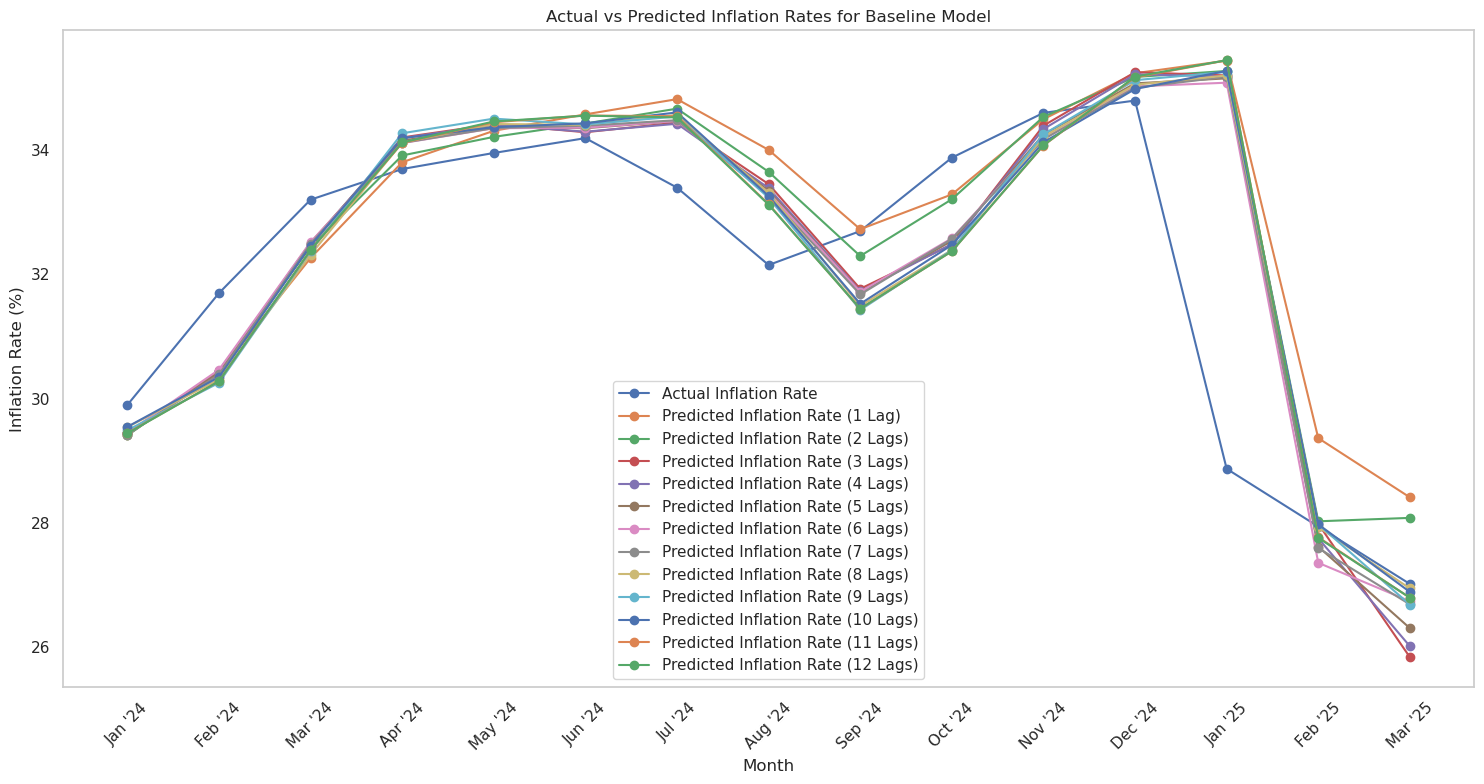

In [97]:
# Plot the actual vs predicted inflation rates
plt.figure(figsize=(15, 8))
plt.plot(predictions_df['Month'], predictions_df['Actual Inflation Rate'], label='Actual Inflation Rate', marker='o')
plt.plot(predictions_df['Month'], predictions_df['Predicted Inflation Rate (1 Lag)'], label='Predicted Inflation Rate (1 Lag)', marker='o')
plt.plot(predictions_df['Month'], predictions_df['Predicted Inflation Rate (2 Lags)'], label='Predicted Inflation Rate (2 Lags)', marker='o')
plt.plot(predictions_df['Month'], predictions_df['Predicted Inflation Rate (3 Lags)'], label='Predicted Inflation Rate (3 Lags)', marker='o')
plt.plot(predictions_df['Month'], predictions_df['Predicted Inflation Rate (4 Lags)'], label='Predicted Inflation Rate (4 Lags)', marker='o')
plt.plot(predictions_df['Month'], predictions_df['Predicted Inflation Rate (5 Lags)'], label='Predicted Inflation Rate (5 Lags)', marker='o')
plt.plot(predictions_df['Month'], predictions_df['Predicted Inflation Rate (6 Lags)'], label='Predicted Inflation Rate (6 Lags)', marker='o')
plt.plot(predictions_df['Month'], predictions_df['Predicted Inflation Rate (7 Lags)'], label='Predicted Inflation Rate (7 Lags)', marker='o')
plt.plot(predictions_df['Month'], predictions_df['Predicted Inflation Rate (8 Lags)'], label='Predicted Inflation Rate (8 Lags)', marker='o')
plt.plot(predictions_df['Month'], predictions_df['Predicted Inflation Rate (9 Lags)'], label='Predicted Inflation Rate (9 Lags)', marker='o')
plt.plot(predictions_df['Month'], predictions_df['Predicted Inflation Rate (10 Lags)'], label='Predicted Inflation Rate (10 Lags)', marker='o')
plt.plot(predictions_df['Month'], predictions_df['Predicted Inflation Rate (11 Lags)'], label='Predicted Inflation Rate (11 Lags)', marker='o')
plt.plot(predictions_df['Month'], predictions_df['Predicted Inflation Rate (12 Lags)'], label='Predicted Inflation Rate (12 Lags)', marker='o')
plt.title('Actual vs Predicted Inflation Rates for Baseline Model')
plt.xlabel('Month')
plt.ylabel('Inflation Rate (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./actual_vs_predicted_inflation_rates_baseline_models.png')
plt.show()

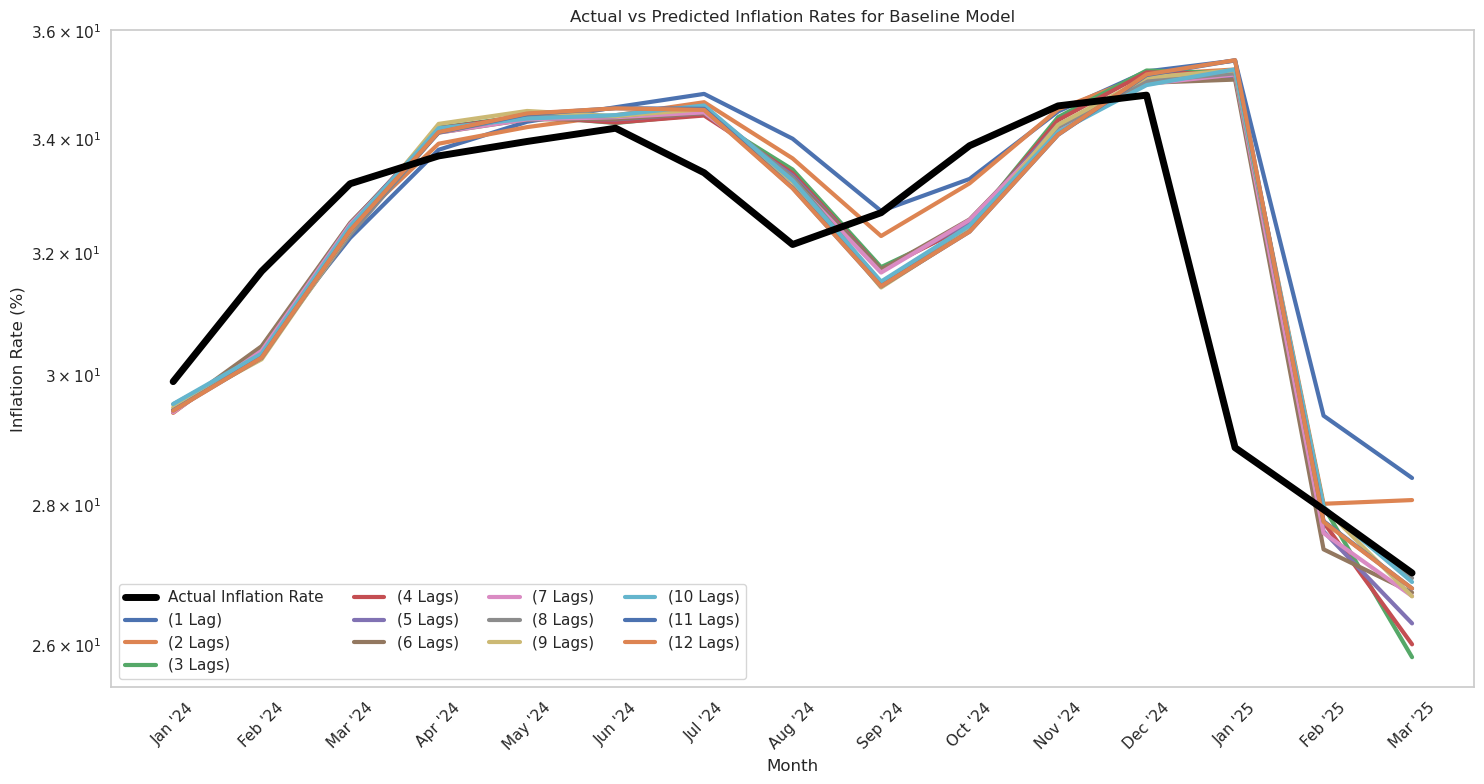

In [98]:
import seaborn as sns

plt.figure(figsize=(15, 8))

# Plot actual inflation rate with highest zorder
sns.lineplot(
    data=predictions_df,
    x='Month',
    y='Actual Inflation Rate',
    label='Actual Inflation Rate',
    linewidth=5,
    color='black',
    zorder=10
)

# Plot predicted inflation rates for each lag (no marker)
for i in range(1, 13):
    sns.lineplot(
        data=predictions_df,
        x='Month',
        y=f'Predicted Inflation Rate ({i} Lag{"s" if i > 1 else ""})',
        label=f'({i} Lag{"s" if i > 1 else ""})',
        linewidth=3,
        zorder=5
    )

plt.title('Actual vs Predicted Inflation Rates for Baseline Model')
plt.xlabel('Month')
plt.ylabel('Inflation Rate (%)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='best', fontsize=11, ncol=4, frameon=True, fancybox=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('./actual_vs_predicted_inflation_rates_baseline_models_seaborn.png')
plt.show()

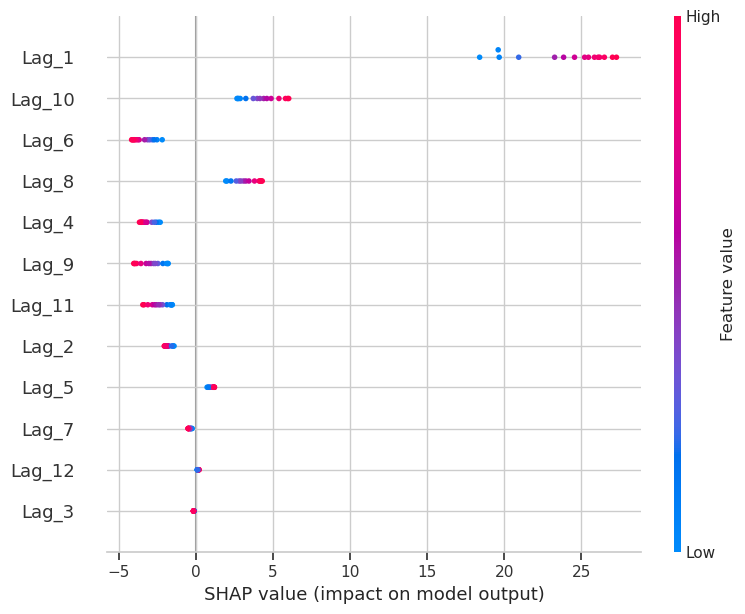

In [116]:
# Create the SHAP explainer
explainer = shap.LinearExplainer(model_12, X_train_12)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_12)

# Plot the SHAP values
shap.summary_plot(shap_values, X_test_12, feature_names=X_test_12.columns, show=True)

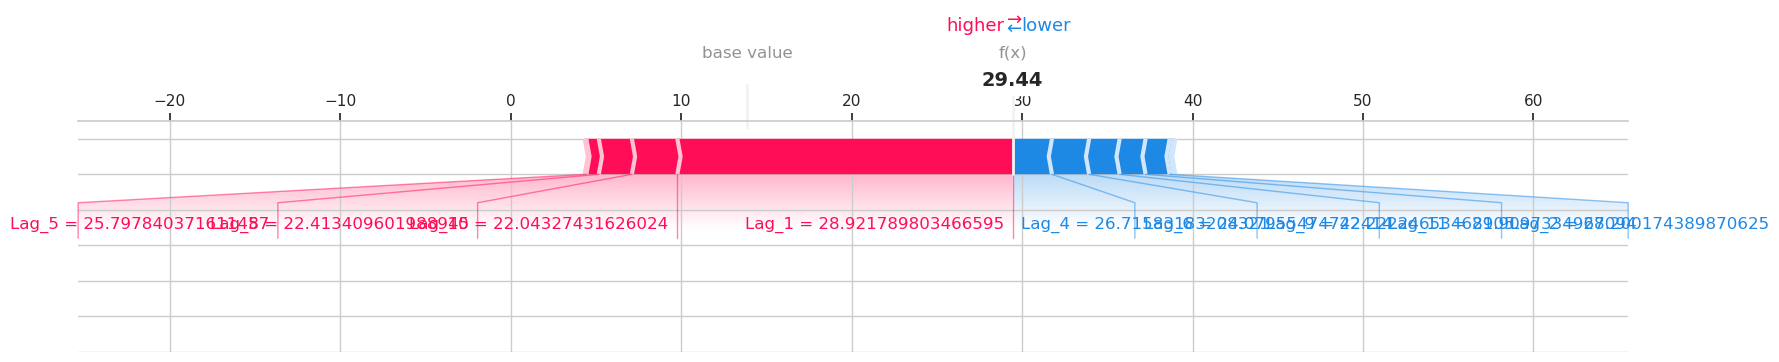

<Figure size 640x480 with 0 Axes>

In [117]:
# Create force plot for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0,:],
                X_test_12.iloc[0,:],
                matplotlib=True,
                show=True)
plt.savefig('./shap_force_plot.png')
plt.show()

In [119]:
# # Calculate mean absolute SHAP values for each feature
# feature_importance = pd.DataFrame({
#     'Feature': lag_features,
#     'Importance': np.abs(shap_values).mean(0)
# })
# feature_importance = feature_importance.sort_values('Importance', ascending=False)

# # Plot feature importance
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Importance', y='Feature', data=feature_importance)
# plt.title('Feature Importance based on SHAP Values')
# plt.tight_layout()
# plt.savefig('./feature_importance_shap.png')
# plt.show()

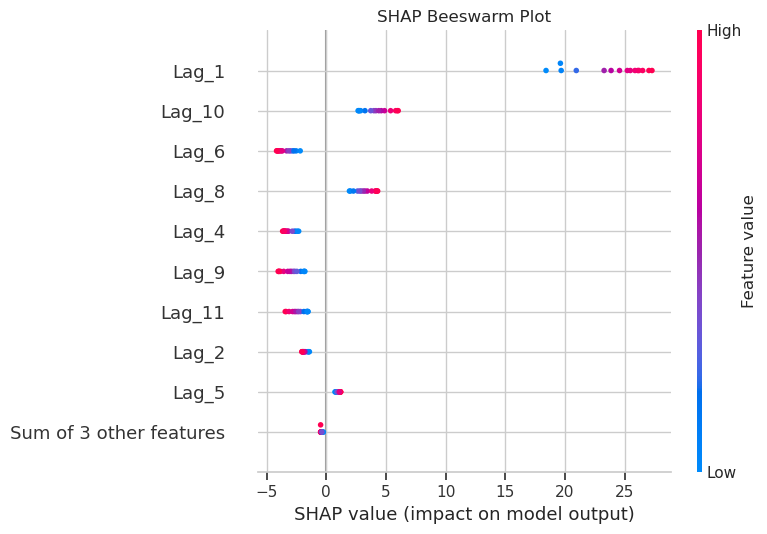

In [120]:
# Create SHAP Beeswarm Plot
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(
    shap.Explanation(
        values=shap_values,
        base_values=explainer.expected_value,
        data=X_test_12,
        feature_names=X_test_12.columns
    ),
    show=False
)
plt.title('SHAP Beeswarm Plot')
plt.tight_layout()
plt.savefig('./shap_beeswarm_plot.png', dpi=300, bbox_inches='tight')
plt.show()

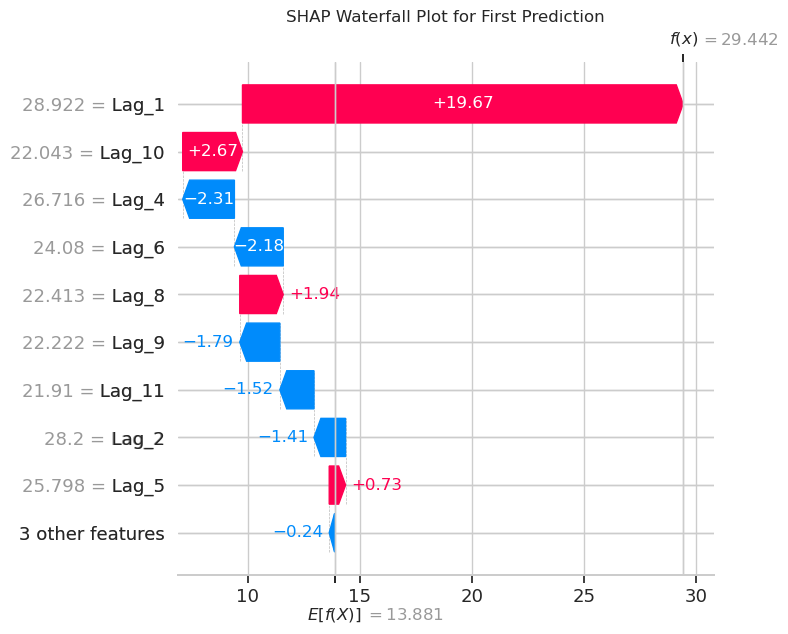

In [121]:
# Create Waterfall Plot for First Prediction

# Get SHAP values for the first prediction
shap_explanation = shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=X_test_12.iloc[0],
    feature_names=X_test_12.columns
)

plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_explanation, show=False)
plt.title('SHAP Waterfall Plot for First Prediction')
plt.tight_layout()
plt.savefig('./shap_waterfall_plot.png', dpi=300, bbox_inches='tight')
plt.show()

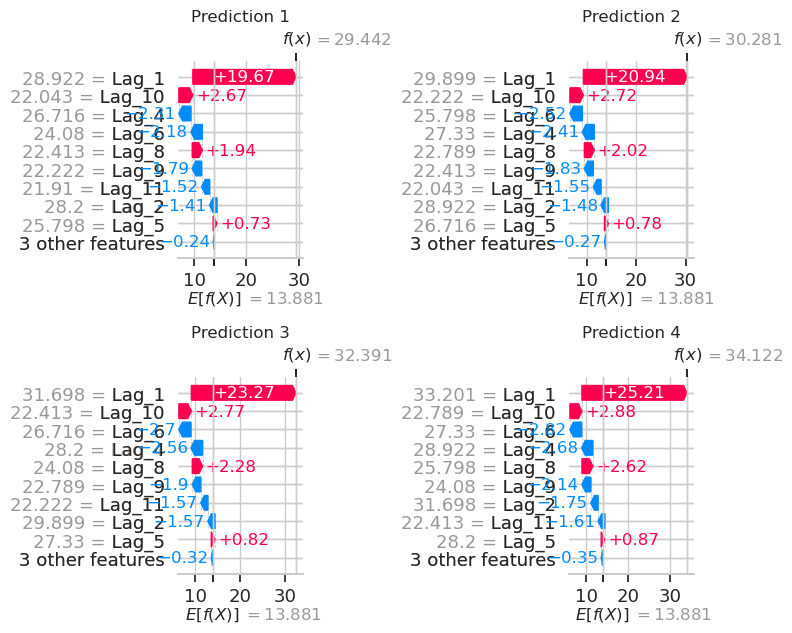

In [122]:
# Create Waterfall Plots for Multiple Predictions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i in range(4):  # Plot first 4 predictions
    shap_explanation = shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_test_12.iloc[i],
        feature_names=X_test_12.columns
    )
    
    plt.sca(axes[i])
    shap.plots.waterfall(shap_explanation, show=False)
    plt.title(f'Prediction {i+1}')

plt.tight_layout()
plt.savefig('./multiple_shap_waterfall_plots.png', dpi=300, bbox_inches='tight')
plt.show()

## Linear Regression with Google Trends Data Only

In [160]:
# load ordered merged data
merged_data.head()

# exclude Lag 1 - Lag 12
merged_data_no_lag = merged_data.drop(columns=['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12'])
merged_data_no_lag = merged_data_no_lag.rename(columns={'Year-on-Year Change (%)': 'Inflation rate'})
merged_data_no_lag.head()

,Month,Rice,Filling station,Gas cylinder,Textile,iPhone,Meter,Food,Mental health,Water,...,Drill,Economics,Petroleum,Data plan,Toyota,Tourism,Recipe,Natural gas,Emirates Telecom,Inflation rate
0,2011-01-01,11.0,22.0,0.0,37.0,25.0,25.0,53.0,37.0,39.0,...,77.0,55.0,79.0,4.0,96.7,97.0,53.0,83.0,35.7,12.079665
1,2011-02-01,11.0,17.0,0.0,45.0,22.0,28.0,52.0,36.0,52.0,...,97.0,69.0,85.0,4.0,95.7,100.0,53.0,87.0,36.6,11.099837
2,2011-03-01,14.0,0.0,0.0,39.0,23.0,28.0,57.0,31.0,55.0,...,100.0,65.0,100.0,3.0,89.7,99.0,52.0,100.0,46.3,12.779128
3,2011-04-01,11.0,22.0,0.0,39.0,22.0,21.0,52.0,20.0,46.0,...,68.0,59.0,74.0,7.0,89.7,98.0,57.0,90.0,42.4,11.291282
4,2011-05-01,12.0,26.0,0.0,38.0,24.0,26.0,56.0,30.0,51.0,...,91.0,68.0,80.0,7.0,99.7,99.0,53.0,88.0,52.1,12.352128


In [161]:
# create temporal split with 2024-01-01 as the split date
split_date = '2024-01-01'  # Define the split date

train_data_no_lag = merged_data_no_lag[merged_data_no_lag['Month'] < split_date]
test_data_no_lag = merged_data_no_lag[merged_data_no_lag['Month'] >= split_date]

# display the first few rows of the train and test DataFrames
# display(train_data_no_lag)
# display(test_data_no_lag)
# print the shape of the train and test data
print(f"Train data shape: {train_data_no_lag.shape}")
print(f"Test data shape: {test_data_no_lag.shape}")


Train data shape: (156, 128)
Test data shape: (15, 128)


In [162]:
# Create different versions of X_train and X_test with different count of features (1, 20, 40, 60, 80, 100, 120, 126 keywords)

X_train_1_k = train_data_no_lag.iloc[:, 1:2]
X_train_20_k = train_data_no_lag.iloc[:, 1:21]
X_train_40_k = train_data_no_lag.iloc[:, 1:41]
X_train_60_k = train_data_no_lag.iloc[:, 1:61]
X_train_80_k = train_data_no_lag.iloc[:, 1:81]
X_train_100_k = train_data_no_lag.iloc[:, 1:101]
X_train_120_k = train_data_no_lag.iloc[:, 1:121]
X_train_126_k = train_data_no_lag.iloc[:, 1:-1]  # Exclude the last column (Inflation rate)

# print the shape of the X-train data
print(f"X_train_1_k shape: {X_train_1_k.shape}")
print(f"X_train_20_k shape: {X_train_20_k.shape}")
print(f"X_train_40_k shape: {X_train_40_k.shape}")
print(f"X_train_60_k shape: {X_train_60_k.shape}")
print(f"X_train_80_k shape: {X_train_80_k.shape}")
print(f"X_train_100_k shape: {X_train_100_k.shape}")
print(f"X_train_120_k shape: {X_train_120_k.shape}")
print(f"X_train_126_k shape: {X_train_126_k.shape}")

# display(X_train_126_k)

# Get y-train for 1 - 126 keywords
y_train = train_data_no_lag.iloc[:, -1]  # Get the last column (Inflation rate)
# print the shape of the y-train data
print(f"y_train shape: {y_train.shape}")

# Get X-test
X_test_1_k = test_data_no_lag.iloc[:, 1:2]
X_test_20_k = test_data_no_lag.iloc[:, 1:21]
X_test_40_k = test_data_no_lag.iloc[:, 1:41]
X_test_60_k = test_data_no_lag.iloc[:, 1:61]
X_test_80_k = test_data_no_lag.iloc[:, 1:81]
X_test_100_k = test_data_no_lag.iloc[:, 1:101]
X_test_120_k = test_data_no_lag.iloc[:, 1:121]
X_test_126_k = test_data_no_lag.iloc[:, 1:-1]  # Exclude the last column (Inflation rate)

# print the shape of the X-test data
print(f"X_test_1_k shape: {X_test_1_k.shape}")
print(f"X_test_20_k shape: {X_test_20_k.shape}")
print(f"X_test_40_k shape: {X_test_40_k.shape}")
print(f"X_test_60_k shape: {X_test_60_k.shape}")
print(f"X_test_80_k shape: {X_test_80_k.shape}")
print(f"X_test_100_k shape: {X_test_100_k.shape}")
print(f"X_test_120_k shape: {X_test_120_k.shape}")
print(f"X_test_126_k shape: {X_test_126_k.shape}")

# Get y-test
y_test_no_lag = test_data_no_lag.iloc[:, -1]  # Get the last column (Inflation rate)
# print the shape of the y-test data
print(f"y_test_no_lag shape: {y_test_no_lag.shape}")


X_train_1_k shape: (156, 1)
X_train_20_k shape: (156, 20)
X_train_40_k shape: (156, 40)
X_train_60_k shape: (156, 60)
X_train_80_k shape: (156, 80)
X_train_100_k shape: (156, 100)
X_train_120_k shape: (156, 120)
X_train_126_k shape: (156, 126)
y_train shape: (156,)
X_test_1_k shape: (15, 1)
X_test_20_k shape: (15, 20)
X_test_40_k shape: (15, 40)
X_test_60_k shape: (15, 60)
X_test_80_k shape: (15, 80)
X_test_100_k shape: (15, 100)
X_test_120_k shape: (15, 120)
X_test_126_k shape: (15, 126)
y_test_no_lag shape: (15,)


In [163]:
# Create models for different number of features
model_1_k = LinearRegression().fit(X_train_1_k, y_train)
model_20_k = LinearRegression().fit(X_train_20_k, y_train)
model_40_k = LinearRegression().fit(X_train_40_k, y_train)
model_60_k = LinearRegression().fit(X_train_60_k, y_train)
model_80_k = LinearRegression().fit(X_train_80_k, y_train)
model_100_k = LinearRegression().fit(X_train_100_k, y_train)
model_120_k = LinearRegression().fit(X_train_120_k, y_train)
model_126_k = LinearRegression().fit(X_train_126_k, y_train)

# get the predictions for the test data
y_pred_1_k = model_1_k.predict(X_test_1_k)
y_pred_20_k = model_20_k.predict(X_test_20_k)
y_pred_40_k = model_40_k.predict(X_test_40_k)
y_pred_60_k = model_60_k.predict(X_test_60_k)
y_pred_80_k = model_80_k.predict(X_test_80_k)
y_pred_100_k = model_100_k.predict(X_test_100_k)
y_pred_120_k = model_120_k.predict(X_test_120_k)
y_pred_126_k = model_126_k.predict(X_test_126_k)


In [164]:
# FULL TEST SET

# Calculate metrics for each model
metrics_1_k = calculate_metrics(y_test_no_lag, y_pred_1_k)
metrics_20_k = calculate_metrics(y_test_no_lag, y_pred_20_k)
metrics_40_k = calculate_metrics(y_test_no_lag, y_pred_40_k)
metrics_60_k = calculate_metrics(y_test_no_lag, y_pred_60_k)
metrics_80_k = calculate_metrics(y_test_no_lag, y_pred_80_k)
metrics_100_k = calculate_metrics(y_test_no_lag, y_pred_100_k)
metrics_120_k = calculate_metrics(y_test_no_lag, y_pred_120_k)
metrics_126_k = calculate_metrics(y_test_no_lag, y_pred_126_k)

# Create a DataFrame to store the metrics
metrics_df_no_lag = pd.DataFrame({
    'Model': ['1 Keyword', '20 Keywords', '40 Keywords', '60 Keywords', '80 Keywords', 
              '100 Keywords', '120 Keywords', '126 Keywords'],
    'RMSE': [metrics_1_k[0], metrics_20_k[0], metrics_40_k[0], metrics_60_k[0], 
             metrics_80_k[0], metrics_100_k[0], metrics_120_k[0], metrics_126_k[0]],
    'MAE': [metrics_1_k[1], metrics_20_k[1], metrics_40_k[1], metrics_60_k[1], 
            metrics_80_k[1], metrics_100_k[1], metrics_120_k[1], metrics_126_k[1]],
    'RMSPE': [metrics_1_k[2], metrics_20_k[2], metrics_40_k[2], metrics_60_k[2],
              metrics_80_k[2],  metrics_100_k[2],
              metrics_120_k[2],  metrics_126_k[2]],
    'MAPE': [metrics_1_k[3], metrics_20_k[3], metrics_40_k[3], metrics_60_k[3],
             metrics_80_k[3],
             metrics_100_k[3],
             metrics_120_k[3],
             metrics_126_k[3]],
    'R-squared': [metrics_1_k[-1], metrics_20_k[-1], metrics_40_k[-1], 
                  metrics_60_k[-1], 
                  metrics_80_k[-1],
                  metrics_100_k[-1],
                  metrics_120_k[-1],
                  metrics_126_k[-1]]
})

# Print the metrics DataFrame
metrics_df_no_lag = metrics_df_no_lag.round(2)
display(metrics_df_no_lag)

,Model,RMSE,MAE,RMSPE,MAPE,R-squared
0,1 Keyword,9.79,9.24,29.85,28.47,-15.19
1,20 Keywords,8.36,8.00,25.38,24.50,-10.81
2,40 Keywords,6.91,6.62,21.10,20.39,-7.07
3,60 Keywords,6.90,6.49,20.95,19.91,-7.04
4,80 Keywords,5.29,4.71,15.93,14.30,-3.74
5,100 Keywords,9.83,8.96,30.20,27.72,-15.33
6,120 Keywords,7.09,6.34,21.61,19.51,-7.50
7,126 Keywords,8.72,7.86,26.79,24.33,-11.85


In [165]:
# Create dataframe for predictions
predictions_df_no_lag = pd.DataFrame({
    'Month': test_data_no_lag['Month'].dt.strftime('%b \'%y').tolist(),
    'Actual Inflation Rate': y_test_no_lag,
    'Predicted Inflation Rate (1 Keyword)': y_pred_1_k,
    'Predicted Inflation Rate (20 Keywords)': y_pred_20_k,
    'Predicted Inflation Rate (40 Keywords)': y_pred_40_k,
    'Predicted Inflation Rate (60 Keywords)': y_pred_60_k,
    'Predicted Inflation Rate (80 Keywords)': y_pred_80_k,
    'Predicted Inflation Rate (100 Keywords)': y_pred_100_k,
    'Predicted Inflation Rate (120 Keywords)': y_pred_120_k,
    'Predicted Inflation Rate (126 Keywords)': y_pred_126_k
})
# print the first few rows of the predictions DataFrame
# display(predictions_df_no_lag)

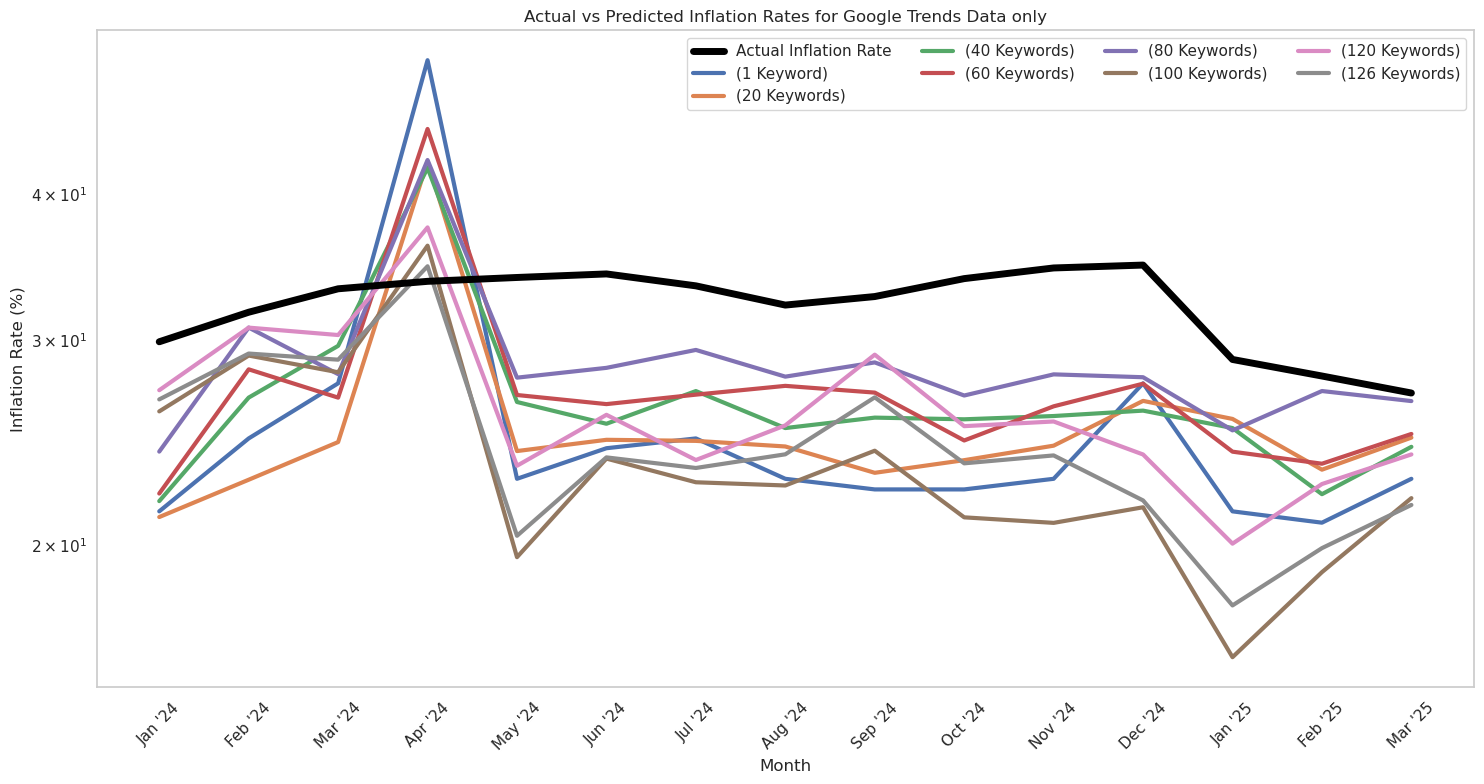

In [166]:
# Plot predictions for different number of features and actual inflation rate using seaborn

import seaborn as sns

plt.figure(figsize=(15, 8))
# Plot actual inflation rate with highest zorder
sns.lineplot(
    data=predictions_df_no_lag,
    x='Month',
    y='Actual Inflation Rate',
    label='Actual Inflation Rate',
    linewidth=5,
    color='black',
    zorder=10
)

# Plot predicted inflation rates for each number of features (no marker)
for i in [1, 20, 40, 60, 80, 100, 120, 126]:
    sns.lineplot(
        data=predictions_df_no_lag,
        x='Month',
        y=f'Predicted Inflation Rate ({i} Keyword{"s" if i > 1 else ""})',
        label=f'({i} Keyword{"s" if i > 1 else ""})',
        linewidth=3,
        zorder=5
    )
plt.title('Actual vs Predicted Inflation Rates for Google Trends Data only')
plt.xlabel('Month')
plt.ylabel('Inflation Rate (%)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='best', fontsize=11, ncol=4, frameon=True, fancybox=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('./actual_vs_predicted_inflation_rates_baseline_models_no_lag_seaborn.png')
plt.show()

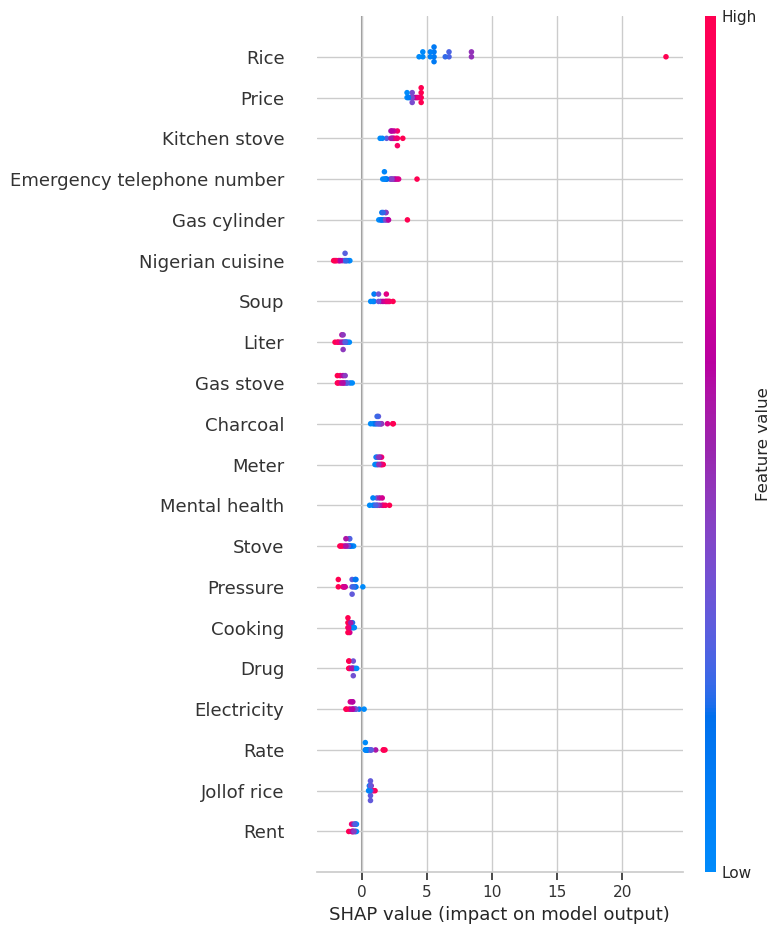

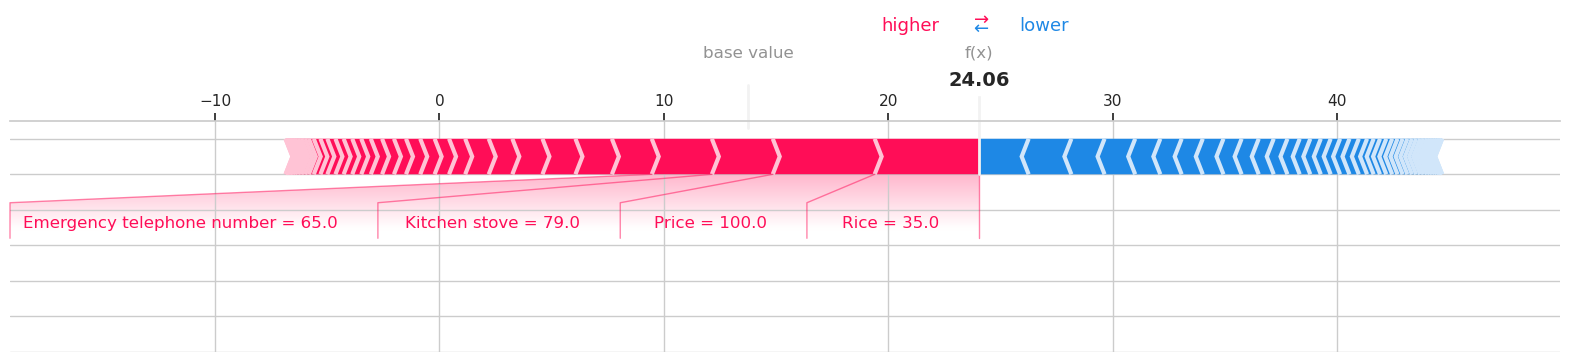

<Figure size 640x480 with 0 Axes>

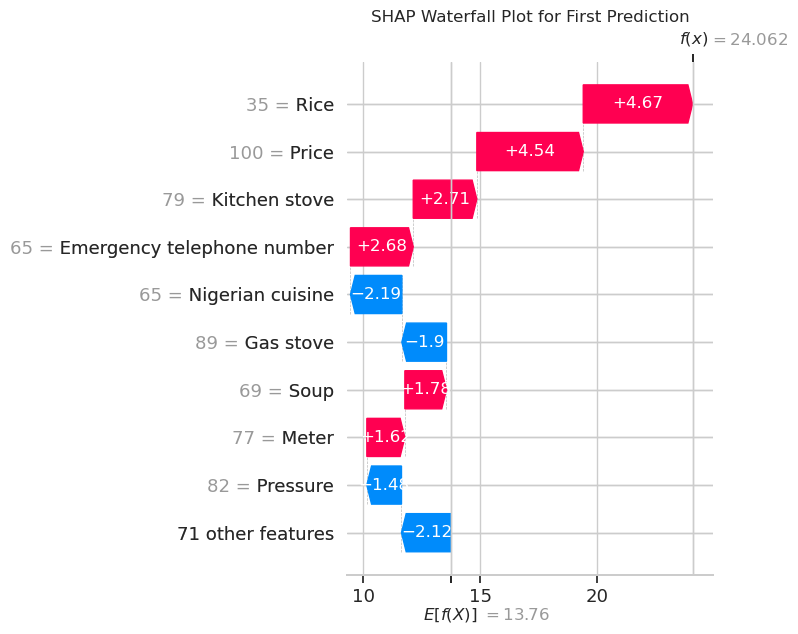

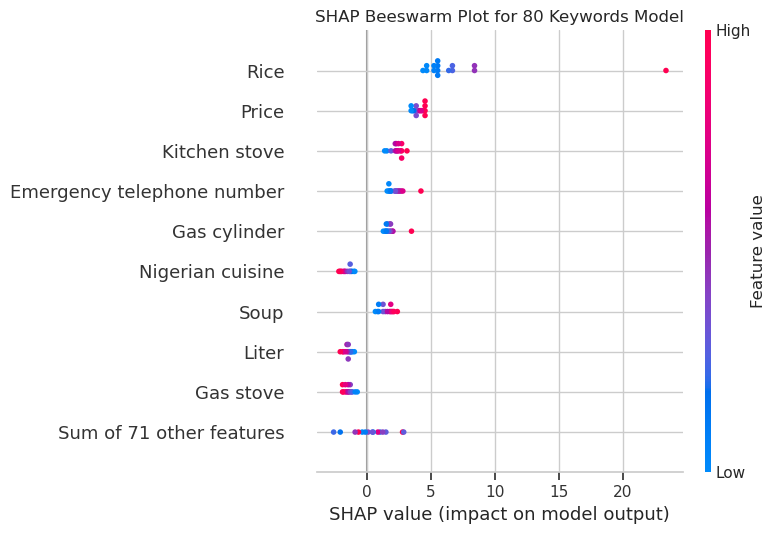

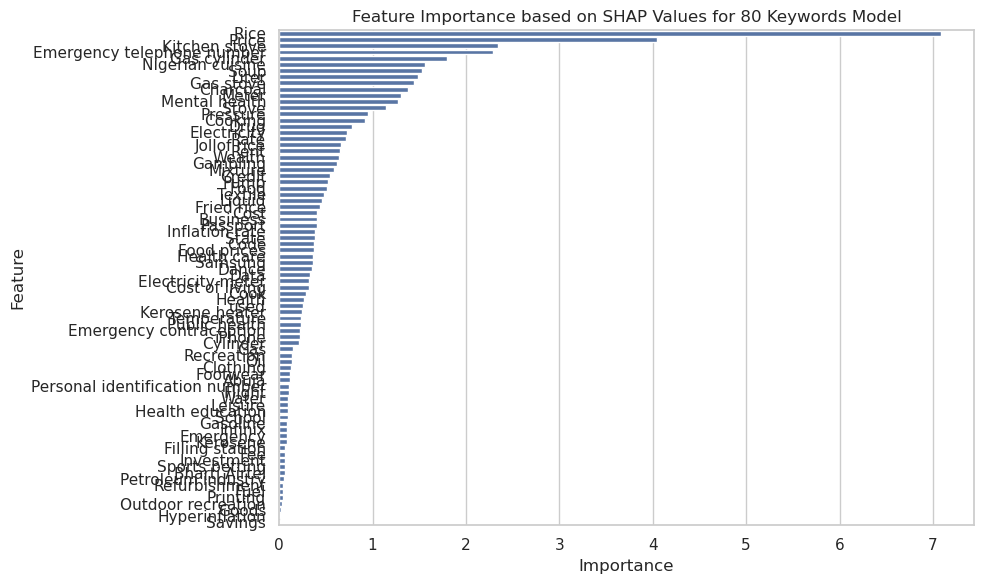

In [167]:
# get the SHAP values for the model with 80 keywords model

# Summary Plot
explainer = shap.LinearExplainer(model_80_k, X_train_80_k)
shap_values = explainer.shap_values(X_test_80_k)
shap.summary_plot(shap_values, X_test_80_k, feature_names=X_test_80_k.columns, show=True)

# Force Plot
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[0,:],
                X_test_80_k.iloc[0,:],
                matplotlib=True,
                show=True)
plt.savefig('./shap_force_plot_80_keywords.png')
plt.show()


# Waterfall Plot
# shap.waterfall_plot(explainer.expected_value, 
#                      shap_values[0,:],
#                      X_test_80_k.iloc[0,:],
#                      show=True)
# plt.savefig('./shap_waterfall_plot_80_keywords.png')
# plt.show()

# Get SHAP values for the first prediction
shap_explanation = shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=X_test_80_k.iloc[0],
    feature_names=X_test_80_k.columns
)

plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_explanation, show=False)
plt.title('SHAP Waterfall Plot for First Prediction')
plt.tight_layout()
plt.savefig('./shap_waterfall_plot_80_keywords.png', dpi=300, bbox_inches='tight')
plt.show()

# Beeswarm Plot
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(
    shap.Explanation(
        values=shap_values,
        base_values=explainer.expected_value,
        data=X_test_80_k,
        feature_names=X_test_80_k.columns
    ),
    show=False
)
plt.title('SHAP Beeswarm Plot for 80 Keywords Model')
plt.tight_layout()
plt.savefig('./shap_beeswarm_plot_80_keywords.png', dpi=300, bbox_inches='tight')
plt.show()


# Feature Importance Plot
# Calculate mean absolute SHAP values for each feature
feature_importance = pd.DataFrame({
    'Feature': X_train_80_k.columns,
    'Importance': np.abs(shap_values).mean(0)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance based on SHAP Values for 80 Keywords Model')
plt.tight_layout()
plt.savefig('./feature_importance_shap_80_keywords.png')
plt.show()


In [168]:
# TEST SET beFORE REBASE (Jan 2024 - Dec 2024)
# first 12 months in the test set

# Get the first 12 months of the test set
metrics_1_k = calculate_metrics(y_test_no_lag[:12], y_pred_1_k[:12])
metrics_20_k = calculate_metrics(y_test_no_lag[:12], y_pred_20_k[:12])
metrics_40_k = calculate_metrics(y_test_no_lag[:12], y_pred_40_k[:12])
metrics_60_k = calculate_metrics(y_test_no_lag[:12], y_pred_60_k[:12])
metrics_80_k = calculate_metrics(y_test_no_lag[:12], y_pred_80_k[:12])
metrics_100_k = calculate_metrics(y_test_no_lag[:12], y_pred_100_k[:12])
metrics_120_k = calculate_metrics(y_test_no_lag[:12], y_pred_120_k[:12])
metrics_126_k = calculate_metrics(y_test_no_lag[:12], y_pred_126_k[:12])

# create a DataFrame to store the metrics
metrics_df_no_lag = pd.DataFrame({
    'Model': ['1 Keyword', '20 Keywords', '40 Keywords', '60 Keywords', '80 Keywords', 
              '100 Keywords', '120 Keywords', '126 Keywords'],
    'RMSE': [metrics_1_k[0], metrics_20_k[0], metrics_40_k[0], metrics_60_k[0], 
             metrics_80_k[0], metrics_100_k[0], metrics_120_k[0], metrics_126_k[0]],
    'MAE': [metrics_1_k[1], metrics_20_k[1], metrics_40_k[1], metrics_60_k[1], 
            metrics_80_k[1], metrics_100_k[1], metrics_120_k[1], metrics_126_k[1]],
    'RMSPE': [metrics_1_k[2], metrics_20_k[2], metrics_40_k[2], metrics_60_k[2],
              metrics_80_k[2],  metrics_100_k[2],
              metrics_120_k[2],  metrics_126_k[2]],
    'MAPE': [metrics_1_k[3], metrics_20_k[3], metrics_40_k[3], metrics_60_k[3],
             metrics_80_k[3],
             metrics_100_k[3],
             metrics_120_k[3],
             metrics_126_k[3]],
    'R-squared': [metrics_1_k[-1], metrics_20_k[-1], metrics_40_k[-1], 
                  metrics_60_k[-1], 
                  metrics_80_k[-1],
                  metrics_100_k[-1],
                  metrics_120_k[-1],
                  metrics_126_k[-1]]
})

# display the metrics DataFrame
metrics_df_no_lag = metrics_df_no_lag.round(2)
metrics_df_no_lag

,Model,RMSE,MAE,RMSPE,MAPE,R-squared
0,1 Keyword,10.47,9.98,31.38,30.03,-60.73
1,20 Keywords,9.18,9.15,27.66,27.58,-46.45
2,40 Keywords,7.43,7.26,22.33,21.85,-30.09
3,60 Keywords,7.46,7.16,22.35,21.52,-30.32
4,80 Keywords,5.81,5.47,17.38,16.41,-18.04
5,100 Keywords,9.91,8.96,29.32,26.70,-54.34
6,120 Keywords,7.30,6.49,21.54,19.28,-29.00
7,126 Keywords,8.77,7.78,25.91,23.15,-42.36


In [169]:
# TEST DATA AFTER REBASE
# calculate the metrics for each model for y_test and y_pred last 3 months (Jan - Mar 2025)

# Convert numpy arrays to pandas Series for consistent indexing
y_pred_1_k_series = pd.Series(y_pred_1_k, index=y_test_no_lag.index)
y_pred_20_k_series = pd.Series(y_pred_20_k, index=y_test_no_lag.index)
y_pred_40_k_series = pd.Series(y_pred_40_k, index=y_test_no_lag.index)
y_pred_60_k_series = pd.Series(y_pred_60_k, index=y_test_no_lag.index)
y_pred_80_k_series = pd.Series(y_pred_80_k, index=y_test_no_lag.index)
y_pred_100_k_series = pd.Series(y_pred_100_k, index=y_test_no_lag.index)
y_pred_120_k_series = pd.Series(y_pred_120_k, index=y_test_no_lag.index)
y_pred_126_k_series = pd.Series(y_pred_126_k, index=y_test_no_lag.index)

# Now calculate metrics using the Series objects
metrics_1_k = calculate_metrics(y_test_no_lag.iloc[-3:], y_pred_1_k_series.iloc[-3:])
metrics_20_k = calculate_metrics(y_test_no_lag.iloc[-3:], y_pred_20_k_series.iloc[-3:])
metrics_40_k = calculate_metrics(y_test_no_lag.iloc[-3:], y_pred_40_k_series.iloc[-3:])
metrics_60_k = calculate_metrics(y_test_no_lag.iloc[-3:], y_pred_60_k_series.iloc[-3:])
metrics_80_k = calculate_metrics(y_test_no_lag.iloc[-3:], y_pred_80_k_series.iloc[-3:])
metrics_100_k = calculate_metrics(y_test_no_lag.iloc[-3:], y_pred_100_k_series.iloc[-3:])
metrics_120_k = calculate_metrics(y_test_no_lag.iloc[-3:], y_pred_120_k_series.iloc[-3:])
metrics_126_k = calculate_metrics(y_test_no_lag.iloc[-3:], y_pred_126_k_series.iloc[-3:])

# create a DataFrame to store the metrics
metrics_df_no_lag = pd.DataFrame({
    'Model': ['1 Keyword', '20 Keywords', '40 Keywords', '60 Keywords', '80 Keywords', 
              '100 Keywords', '120 Keywords', '126 Keywords'],
    'RMSE': [metrics_1_k[0], metrics_20_k[0], metrics_40_k[0], metrics_60_k[0], 
             metrics_80_k[0], metrics_100_k[0], metrics_120_k[0], metrics_126_k[0]],
    'MAE': [metrics_1_k[1], metrics_20_k[1], metrics_40_k[1], metrics_60_k[1], 
            metrics_80_k[1], metrics_100_k[1], metrics_120_k[1], metrics_126_k[1]],
    'RMSPE': [metrics_1_k[2], metrics_20_k[2], metrics_40_k[2], metrics_60_k[2],
              metrics_80_k[2],  metrics_100_k[2],
              metrics_120_k[2],  metrics_126_k[2]],
    'MAPE': [metrics_1_k[3], metrics_20_k[3], metrics_40_k[3], metrics_60_k[3],
             metrics_80_k[3],
             metrics_100_k[3],
             metrics_120_k[3],
             metrics_126_k[3]],
    'R-squared': [metrics_1_k[-1], metrics_20_k[-1], metrics_40_k[-1], 
                  metrics_60_k[-1], 
                  metrics_80_k[-1],
                  metrics_100_k[-1],
                  metrics_120_k[-1],
                  metrics_126_k[-1]]
})

# display the metrics DataFrame
metrics_df_no_lag = metrics_df_no_lag.round(2)
metrics_df_no_lag

,Model,RMSE,MAE,RMSPE,MAPE,R-squared
0,1 Keyword,6.41,6.25,22.73,22.24,-70.85
1,20 Keywords,3.55,3.40,12.65,12.15,-21.00
2,40 Keywords,4.27,4.07,15.24,14.54,-30.88
3,60 Keywords,3.97,3.79,14.05,13.46,-26.59
4,80 Keywords,2.24,1.67,7.79,5.86,-7.80
5,100 Keywords,9.51,8.97,33.49,31.80,-157.09
6,120 Keywords,6.22,5.76,21.85,20.40,-66.62
7,126 Keywords,8.51,8.18,30.05,29.07,-125.61


## AR-X

In [205]:
from pmdarima import auto_arima

In [210]:
# create different AR-X models with different number of features
model_ar_1_k = auto_arima(
                            y_train, X=X_train_1_k,
                            start_p=1, max_p=12,
                            d=0,
                            start_q=0, max_q=0,
                            seasonal=False, 
                            stepwise=True, 
                            # trace=True, 
                            information_criterion='bic')
model_ar_20_k = auto_arima(
                            y_train, X=X_train_20_k,
                            start_p=1, max_p=12,
                            d=0,
                            start_q=0, max_q=0,
                            seasonal=False, 
                            stepwise=True, 
                            # trace=True, 
                            information_criterion='bic')
model_ar_40_k = auto_arima(
                            y_train, X=X_train_40_k,
                            start_p=1, max_p=12,
                            d=0,
                            start_q=0, max_q=0,
                            seasonal=False, 
                            stepwise=True, 
                            # trace=True, 
                            information_criterion='bic')
model_ar_60_k = auto_arima(
                            y_train, X=X_train_60_k,
                            start_p=1, max_p=12,
                            d=0,
                            start_q=0, max_q=0,
                            seasonal=False, 
                            stepwise=True, 
                            # trace=True, 
                            information_criterion='bic')
model_ar_80_k = auto_arima(
                            y_train, X=X_train_80_k,
                           start_p=1, max_p=12,
                            d=0,
                            start_q=0, max_q=0,
                            seasonal=False, 
                            stepwise=True, 
                            # trace=True, 
                            information_criterion='bic')
model_ar_100_k = auto_arima(
                            y_train, X=X_train_100_k,
                           start_p=1, max_p=12,
                            d=0,
                            start_q=0, max_q=0,
                            seasonal=False, 
                            stepwise=True, 
                            # trace=True, 
                            information_criterion='bic')
model_ar_120_k = auto_arima(
                            y_train, X=X_train_120_k,
                             start_p=1, max_p=12,
                            d=0,
                            start_q=0, max_q=0,
                            seasonal=False, 
                            stepwise=True, 
                            # trace=True, 
                            information_criterion='bic')
model_ar_126_k = auto_arima(
                            y_train, X=X_train_126_k,
                           start_p=1, max_p=12,
                            d=0,
                            start_q=0, max_q=0,
                            seasonal=False, 
                            stepwise=True, 
                            # trace=True, 
                            information_criterion='bic')

# # create different AR-X models with different number of features
# model_ar_1_k = auto_arima(
#     y_train, X=X_train_1_k,
#     start_p=1, max_p=3,  # Changed from 12 to 3
#     d=0,
#     start_q=0, max_q=0,
#     seasonal=False,
#     stepwise=True,
#     # trace=True,
#     information_criterion='bic'
# )
# model_ar_20_k = auto_arima(
#     y_train, X=X_train_20_k,
#     start_p=1, max_p=3,  # Changed from 12 to 3
#     d=0,
#     start_q=0, max_q=0,
#     seasonal=False,
#     stepwise=True,
#     # trace=True,
#     information_criterion='bic'
# )
# model_ar_40_k = auto_arima(
#     y_train, X=X_train_40_k,
#     start_p=1, max_p=3,  # Changed from 12 to 3
#     d=0,
#     start_q=0, max_q=0,
#     seasonal=False,
#     stepwise=True,
#     # trace=True,
#     information_criterion='bic'
# )
# model_ar_60_k = auto_arima(
#     y_train, X=X_train_60_k,
#     start_p=1, max_p=3,  # Changed from 12 to 3
#     d=0,
#     start_q=0, max_q=0,
#     seasonal=False,
#     stepwise=True,
#     # trace=True,
#     information_criterion='bic'
# )
# model_ar_80_k = auto_arima(
#     y_train, X=X_train_80_k,
#     start_p=1, max_p=3,  # Changed from 12 to 3
#     d=0,
#     start_q=0, max_q=0,
#     seasonal=False,
#     stepwise=True,
#     # trace=True,
#     information_criterion='bic'
# )
# model_ar_100_k = auto_arima(
#     y_train, X=X_train_100_k,
#     start_p=1, max_p=3,  # Changed from 12 to 3
#     d=0,
#     start_q=0, max_q=0,
#     seasonal=False,
#     stepwise=True,
#     # trace=True,
#     information_criterion='bic'
# )
# model_ar_120_k = auto_arima(
#     y_train, X=X_train_120_k,
#     start_p=1, max_p=3,  # Changed from 12 to 3
#     d=0,
#     start_q=0, max_q=0,
#     seasonal=False,
#     stepwise=True,
#     # trace=True,
#     information_criterion='bic'
# )
# model_ar_126_k = auto_arima(
#     y_train, X=X_train_126_k,
#     start_p=1, max_p=3,  # Changed from 12 to 3
#     d=0,
#     start_q=0, max_q=0,
#     seasonal=False,
#     stepwise=True,
#     # trace=True,
#     information_criterion='bic'
# )




/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/

In [211]:
# get prediction for model_ar_1_k
y_pred_ar_1_k = model_ar_1_k.predict(n_periods=len(X_test_1_k), X=X_test_1_k)
y_pred_ar_20_k = model_ar_20_k.predict(n_periods=len(X_test_20_k), X=X_test_20_k)
y_pred_ar_40_k = model_ar_40_k.predict(n_periods=len(X_test_40_k), X=X_test_40_k)
y_pred_ar_60_k = model_ar_60_k.predict(n_periods=len(X_test_60_k), X=X_test_60_k)
y_pred_ar_80_k = model_ar_80_k.predict(n_periods=len(X_test_80_k), X=X_test_80_k)
y_pred_ar_100_k = model_ar_100_k.predict(n_periods=len(X_test_100_k), X=X_test_100_k)
y_pred_ar_120_k = model_ar_120_k.predict(n_periods=len(X_test_120_k), X=X_test_120_k)
y_pred_ar_126_k = model_ar_126_k.predict(n_periods=len(X_test_126_k), X=X_test_126_k)

/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/

In [212]:
# Calculate metrics for each model
metrics_ar_1_k = calculate_metrics(y_test_no_lag, y_pred_ar_1_k)
metrics_ar_20_k = calculate_metrics(y_test_no_lag, y_pred_ar_20_k)
metrics_ar_40_k = calculate_metrics(y_test_no_lag, y_pred_ar_40_k)
metrics_ar_60_k = calculate_metrics(y_test_no_lag, y_pred_ar_60_k)
metrics_ar_80_k = calculate_metrics(y_test_no_lag, y_pred_ar_80_k)
metrics_ar_100_k = calculate_metrics(y_test_no_lag, y_pred_ar_100_k)
metrics_ar_120_k = calculate_metrics(y_test_no_lag, y_pred_ar_120_k)
metrics_ar_126_k = calculate_metrics(y_test_no_lag, y_pred_ar_126_k)

# create a DataFrame to store the metrics
metrics_df_ar = pd.DataFrame({
    'Model': ['1 Keyword', '20 Keywords', '40 Keywords', '60 Keywords', '80 Keywords', 
              '100 Keywords', '120 Keywords', '126 Keywords'],
    'RMSE': [metrics_ar_1_k[0], metrics_ar_20_k[0], metrics_ar_40_k[0], metrics_ar_60_k[0], 
             metrics_ar_80_k[0], metrics_ar_100_k[0], metrics_ar_120_k[0], metrics_ar_126_k[0]],
    'MAE': [metrics_ar_1_k[1], metrics_ar_20_k[1], metrics_ar_40_k[1], metrics_ar_60_k[1], 
            metrics_ar_80_k[1], metrics_ar_100_k[1], metrics_ar_120_k[1], metrics_ar_126_k[1]],
    'RMSPE': [metrics_ar_1_k[2], metrics_ar_20_k[2], metrics_ar_40_k[2], metrics_ar_60_k[2],
              metrics_ar_80_k[2],  metrics_ar_100_k[2],
              metrics_ar_120_k[2],  metrics_ar_126_k[2]],
    'MAPE': [metrics_ar_1_k[3], metrics_ar_20_k[3], metrics_ar_40_k[3], metrics_ar_60_k[3],
             metrics_ar_80_k[3],
             metrics_ar_100_k[3],
             metrics_ar_120_k[3],
             metrics_ar_126_k[3]],
    'R-squared': [metrics_ar_1_k[-1], metrics_ar_20_k[-1], metrics_ar_40_k[-1], 
                  metrics_ar_60_k[-1], 
                  metrics_ar_80_k[-1],
                  metrics_ar_100_k[-1],
                  metrics_ar_120_k[-1],
                  metrics_ar_126_k[-1]]
})
# display the metrics DataFrame
metrics_df_ar = metrics_df_ar.round(2)
metrics_df_ar

,Model,RMSE,MAE,RMSPE,MAPE,R-squared
0,1 Keyword,9.79,9.24,29.85,28.47,-15.19
1,20 Keywords,7.78,7.35,23.63,22.59,-9.22
2,40 Keywords,8.38,7.87,25.45,24.21,-10.86
3,60 Keywords,10.58,10.02,32.28,30.88,-17.92
4,80 Keywords,8.26,7.84,25.08,24.10,-10.51
5,100 Keywords,11.93,10.98,36.77,34.05,-23.03
6,120 Keywords,8.38,7.98,25.80,24.72,-10.86
7,126 Keywords,10.77,10.35,33.46,32.24,-18.59


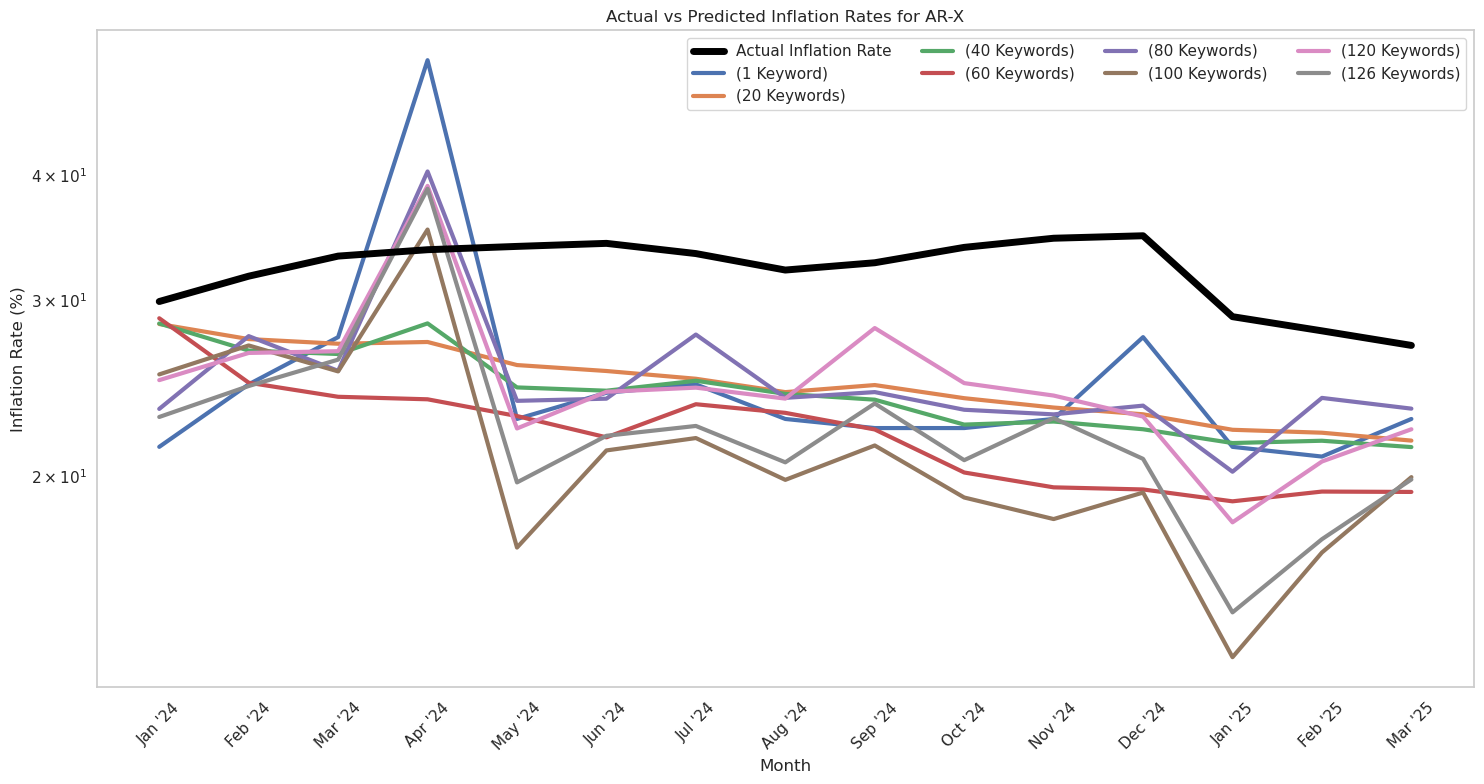

In [214]:

# Create a DataFrame for the predictions
predictions_df_ar = pd.DataFrame({
    'Month': test_data_no_lag['Month'].dt.strftime('%b \'%y').tolist(),
    'Actual Inflation Rate': y_test_no_lag,
    'Predicted Inflation Rate (1 Keyword)': y_pred_ar_1_k,
    'Predicted Inflation Rate (20 Keywords)': y_pred_ar_20_k,
    'Predicted Inflation Rate (40 Keywords)': y_pred_ar_40_k,
    'Predicted Inflation Rate (60 Keywords)': y_pred_ar_60_k,
    'Predicted Inflation Rate (80 Keywords)': y_pred_ar_80_k,
    'Predicted Inflation Rate (100 Keywords)': y_pred_ar_100_k,
    'Predicted Inflation Rate (120 Keywords)': y_pred_ar_120_k,
    'Predicted Inflation Rate (126 Keywords)': y_pred_ar_126_k
})
# print the first few rows of the predictions DataFrame
# display(predictions_df_ar)
# Plot predictions for different number of features and actual inflation rate using seaborn
plt.figure(figsize=(15, 8))
# Plot actual inflation rate with highest zorder
sns.lineplot(
    data=predictions_df_ar,
    x='Month',
    y='Actual Inflation Rate',
    label='Actual Inflation Rate',
    linewidth=5,
    color='black',
    zorder=10
)
# Plot predicted inflation rates for each number of features (no marker)
for i in [1, 20, 40, 60, 80, 100, 120, 126]:
    sns.lineplot(
        data=predictions_df_ar,
        x='Month',
        y=f'Predicted Inflation Rate ({i} Keyword{"s" if i > 1 else ""})',
        label=f'({i} Keyword{"s" if i > 1 else ""})',
        linewidth=3,
        zorder=5
    )
plt.title('Actual vs Predicted Inflation Rates for AR-X')
plt.xlabel('Month')
plt.ylabel('Inflation Rate (%)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='best', fontsize=11, ncol=4, frameon=True, fancybox=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('./actual_vs_predicted_inflation_rates_arx.png')
plt.show()

In [197]:
# # Create waterfall plot for the first prediction of model_ar_20_k
# explainer = shap.LinearExplainer(model_ar_20_k, X_train_20_k)
# shap_values = explainer.shap_values(X_test_20_k)

# shap_explanation = shap.Explanation(
#     values=shap_values[0],
#     base_values=explainer.expected_value,
#     data=X_test_20_k.iloc[0],
#     feature_names=X_test_20_k.columns
# )

# plt.figure(figsize=(10, 6))
# shap.plots.waterfall(shap_explanation, show=False)
# plt.title('SHAP Waterfall Plot for First Prediction of AR-X Model with 20 Keywords')
# plt.tight_layout()
# plt.savefig('./shap_waterfall_plot_ar_20_keywords.png', dpi=300, bbox_inches='tight')
# plt.show()

# # Beeswarm Plot for AR-X Model with 20 Keywords
# plt.figure(figsize=(12, 8))
# shap.plots.beeswarm(
#     shap.Explanation(
#         values=shap_values,
#         base_values=explainer.expected_value,
#         data=X_test_20_k,
#         feature_names=X_test_20_k.columns
#     ),
#     show=False
# )
# plt.title('SHAP Beeswarm Plot for AR-X Model with 20 Keywords')
# plt.tight_layout()
# plt.savefig('./shap_beeswarm_plot_ar_20_keywords.png', dpi=300, bbox_inches='tight')
# plt.show()

## ARIMA-X

In [198]:
# create different ARIMA-X models with different number of features
model_arima_1_k = auto_arima(
    y_train, X=X_train_1_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=False, 
    stepwise=False, 
    # trace=True, 
    information_criterion='bic'
)
model_arima_20_k = auto_arima(
    y_train, X=X_train_20_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=False, 
    stepwise=False, 
    # trace=True, 
    information_criterion='bic'
)
model_arima_40_k = auto_arima(
    y_train, X=X_train_40_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=False, 
    stepwise=False, 
    # trace=True, 
    information_criterion='bic'
)
model_arima_60_k = auto_arima(
    y_train, X=X_train_60_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=False, 
    stepwise=False, 
    # trace=True, 
    information_criterion='bic'
)
model_arima_80_k = auto_arima(
    y_train, X=X_train_80_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=False, 
    stepwise=False, 
    # trace=True, 
    information_criterion='bic'
)
model_arima_100_k = auto_arima(
    y_train, X=X_train_100_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=False, 
    stepwise=False, 
    # trace=True, 
    information_criterion='bic'
)
model_arima_120_k = auto_arima(
    y_train, X=X_train_120_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=False, 
    stepwise=False, 
    # trace=True, 
    information_criterion='bic'
)
model_arima_126_k = auto_arima(
    y_train, X=X_train_126_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=False, 
    stepwise=False, 
    # trace=True, 
    information_criterion='bic'
)

/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/

In [199]:
# get prediction for model_arima_1_k
y_pred_arima_1_k = model_arima_1_k.predict(n_periods=len(X_test_1_k), X=X_test_1_k)
y_pred_arima_20_k = model_arima_20_k.predict(n_periods=len(X_test_20_k), X=X_test_20_k)
y_pred_arima_40_k = model_arima_40_k.predict(n_periods=len(X_test_40_k), X=X_test_40_k)
y_pred_arima_60_k = model_arima_60_k.predict(n_periods=len(X_test_60_k), X=X_test_60_k)
y_pred_arima_80_k = model_arima_80_k.predict(n_periods=len(X_test_80_k), X=X_test_80_k)
y_pred_arima_100_k = model_arima_100_k.predict(n_periods=len(X_test_100_k), X=X_test_100_k)
y_pred_arima_120_k = model_arima_120_k.predict(n_periods=len(X_test_120_k), X=X_test_120_k)
y_pred_arima_126_k = model_arima_126_k.predict(n_periods=len(X_test_126_k), X=X_test_126_k)

/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/

In [200]:
metrics_arima_1_k = calculate_metrics(y_test_no_lag, y_pred_arima_1_k)
metrics_arima_20_k = calculate_metrics(y_test_no_lag, y_pred_arima_20_k)
metrics_arima_40_k = calculate_metrics(y_test_no_lag, y_pred_arima_40_k)
metrics_arima_60_k = calculate_metrics(y_test_no_lag, y_pred_arima_60_k)
metrics_arima_80_k = calculate_metrics(y_test_no_lag, y_pred_arima_80_k)
metrics_arima_100_k = calculate_metrics(y_test_no_lag, y_pred_arima_100_k)
metrics_arima_120_k = calculate_metrics(y_test_no_lag, y_pred_arima_120_k)
metrics_arima_126_k = calculate_metrics(y_test_no_lag, y_pred_arima_126_k)

In [201]:
# create a DataFrame to store the metrics for ARIMA-X models
metrics_df_arima = pd.DataFrame({
    'Model': ['1 Keyword', '20 Keywords', '40 Keywords', '60 Keywords', '80 Keywords', 
              '100 Keywords', '120 Keywords', '126 Keywords'],
    'RMSE': [metrics_arima_1_k[0], metrics_arima_20_k[0], metrics_arima_40_k[0], metrics_arima_60_k[0], 
             metrics_arima_80_k[0], metrics_arima_100_k[0], metrics_arima_120_k[0], metrics_arima_126_k[0]],
    'MAE': [metrics_arima_1_k[1], metrics_arima_20_k[1], metrics_arima_40_k[1], metrics_arima_60_k[1], 
            metrics_arima_80_k[1], metrics_arima_100_k[1], metrics_arima_120_k[1], metrics_arima_126_k[1]],
    'RMSPE': [metrics_arima_1_k[2], metrics_arima_20_k[2], metrics_arima_40_k[2], metrics_arima_60_k[2],
              metrics_arima_80_k[2],  metrics_arima_100_k[2],
              metrics_arima_120_k[2],  metrics_arima_126_k[2]],
    'MAPE': [metrics_arima_1_k[3], metrics_arima_20_k[3], metrics_arima_40_k[3], metrics_arima_60_k[3],
             metrics_arima_80_k[3],
             metrics_arima_100_k[3],
             metrics_arima_120_k[3],
             metrics_arima_126_k[3]],
    'R-squared': [metrics_arima_1_k[-1], metrics_arima_20_k[-1], metrics_arima_40_k[-1], 
                  metrics_arima_60_k[-1], 
                  metrics_arima_80_k[-1],
                  metrics_arima_100_k[-1],
                  metrics_arima_120_k[-1],
                  metrics_arima_126_k[-1]]
})
# display the metrics DataFrame
metrics_df_arima = metrics_df_arima.round(2)
metrics_df_arima

,Model,RMSE,MAE,RMSPE,MAPE,R-squared
0,1 Keyword,3.29,2.98,9.82,9.05,-0.82
1,20 Keywords,4.32,3.92,12.88,11.90,-2.15
2,40 Keywords,5.01,4.49,14.90,13.53,-3.24
3,60 Keywords,9.82,9.20,30.07,28.42,-15.29
4,80 Keywords,9.70,9.13,29.45,28.11,-14.89
5,100 Keywords,11.93,10.98,36.77,34.05,-23.03
6,120 Keywords,8.27,7.90,25.52,24.48,-10.56
7,126 Keywords,10.99,10.57,34.16,32.90,-19.41


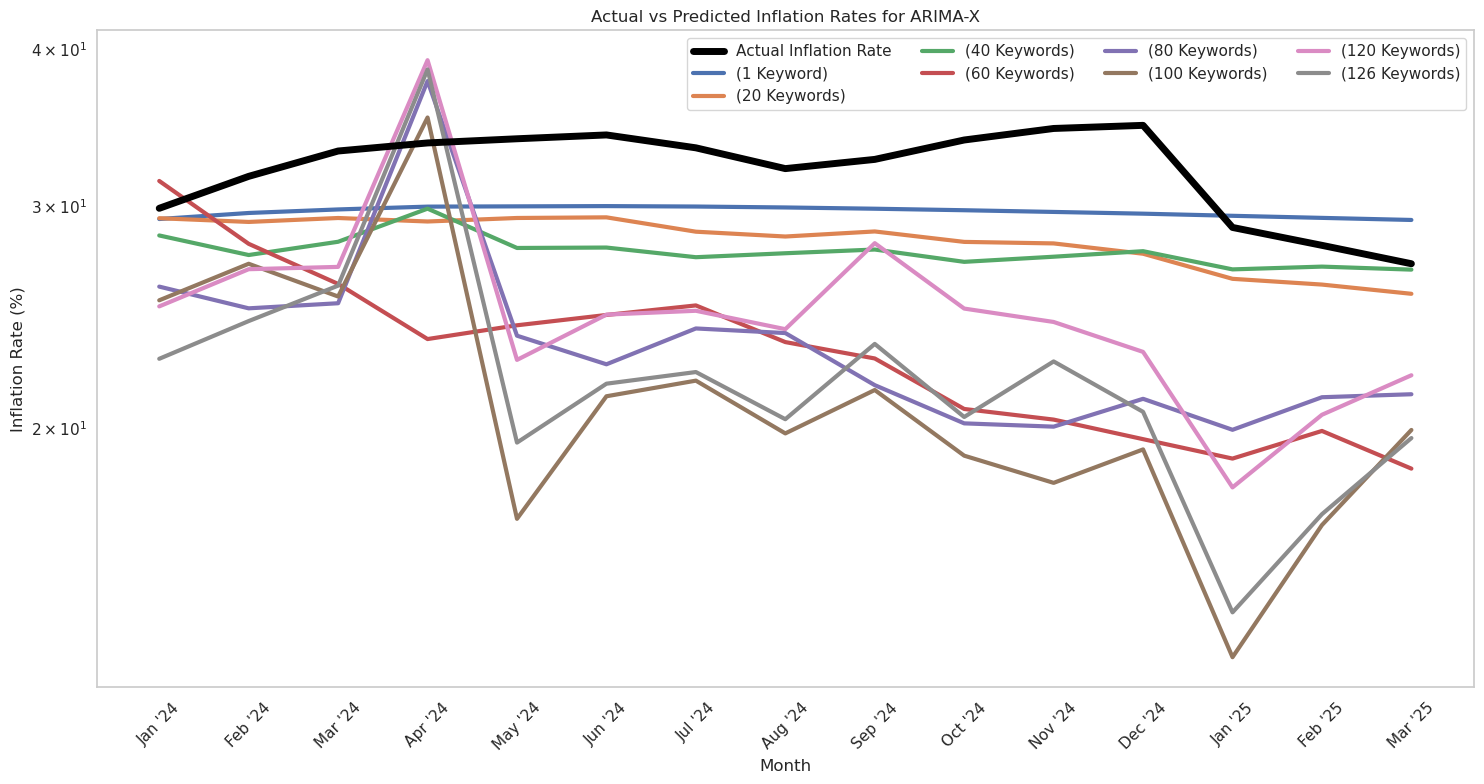

In [215]:
# Create a DataFrame for the predictions (ARIMA-X)
predictions_df_arima = pd.DataFrame({
    'Month': test_data_no_lag['Month'].dt.strftime('%b \'%y').tolist(),
    'Actual Inflation Rate': y_test_no_lag,
    'Predicted Inflation Rate (1 Keyword)': y_pred_arima_1_k,
    'Predicted Inflation Rate (20 Keywords)': y_pred_arima_20_k,
    'Predicted Inflation Rate (40 Keywords)': y_pred_arima_40_k,
    'Predicted Inflation Rate (60 Keywords)': y_pred_arima_60_k,
    'Predicted Inflation Rate (80 Keywords)': y_pred_arima_80_k,
    'Predicted Inflation Rate (100 Keywords)': y_pred_arima_100_k,
    'Predicted Inflation Rate (120 Keywords)': y_pred_arima_120_k,
    'Predicted Inflation Rate (126 Keywords)': y_pred_arima_126_k
})
# print the first few rows of the predictions DataFrame
# display(predictions_df_arima)
# Plot predictions for different number of features and actual inflation rate using seaborn
plt.figure(figsize=(15, 8))
# Plot actual inflation rate with highest zorder
sns.lineplot(
    data=predictions_df_arima,
    x='Month',
    y='Actual Inflation Rate',
    label='Actual Inflation Rate',
    linewidth=5,
    color='black',
    zorder=10
)
# Plot predicted inflation rates for each number of features (no marker)
for i in [1, 20, 40, 60, 80, 100, 120, 126]:
    sns.lineplot(
        data=predictions_df_arima,
        x='Month',
        y=f'Predicted Inflation Rate ({i} Keyword{"s" if i > 1 else ""})',
        label=f'({i} Keyword{"s" if i > 1 else ""})',
        linewidth=3,
        zorder=5
    )
plt.title('Actual vs Predicted Inflation Rates for ARIMA-X')
plt.xlabel('Month')
plt.ylabel('Inflation Rate (%)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='best', fontsize=11, ncol=4, frameon=True, fancybox=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('./actual_vs_predicted_inflation_rates_arimax.png')
plt.show()

## SARIMA-X

In [202]:
# create different SARIMA-X models with different number of features
model_sarima_1_k = auto_arima(
    y_train, X=X_train_1_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=True,           # <-- changed to True
    stepwise=False,
    # trace=True,
    information_criterion='bic'
)
model_sarima_20_k = auto_arima(
    y_train, X=X_train_20_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=True,
    stepwise=False,
    # trace=True,
    information_criterion='bic'
)
model_sarima_40_k = auto_arima(
    y_train, X=X_train_40_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=True,
    stepwise=False,
    # trace=True,
    information_criterion='bic'
)
model_sarima_60_k = auto_arima(
    y_train, X=X_train_60_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=True,
    stepwise=False,
    # trace=True,
    information_criterion='bic'
)
model_sarima_80_k = auto_arima(
    y_train, X=X_train_80_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=True,
    stepwise=False,
    # trace=True,
    information_criterion='bic'
)
model_sarima_100_k = auto_arima(
    y_train, X=X_train_100_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=True,
    stepwise=False,
    # trace=True,
    information_criterion='bic'
)
model_sarima_120_k = auto_arima(
    y_train, X=X_train_120_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=True,
    stepwise=False,
    # trace=True,
    information_criterion='bic'
)
model_sarima_126_k = auto_arima(
    y_train, X=X_train_126_k,
    start_p=1, max_p=12,
    start_q=0, max_q=12,
    seasonal=True,
    stepwise=False,
    # trace=True,
    information_criterion='bic'
)

# get prediction for model_sarima_1_k
y_pred_sarima_1_k = model_sarima_1_k.predict(n_periods=len(X_test_1_k), X=X_test_1_k)
y_pred_sarima_20_k = model_sarima_20_k.predict(n_periods=len(X_test_20_k), X=X_test_20_k)
y_pred_sarima_40_k = model_sarima_40_k.predict(n_periods=len(X_test_40_k), X=X_test_40_k)
y_pred_sarima_60_k = model_sarima_60_k.predict(n_periods=len(X_test_60_k), X=X_test_60_k)
y_pred_sarima_80_k = model_sarima_80_k.predict(n_periods=len(X_test_80_k), X=X_test_80_k)
y_pred_sarima_100_k = model_sarima_100_k.predict(n_periods=len(X_test_100_k), X=X_test_100_k)
y_pred_sarima_120_k = model_sarima_120_k.predict(n_periods=len(X_test_120_k), X=X_test_120_k)
y_pred_sarima_126_k = model_sarima_126_k.predict(n_periods=len(X_test_126_k), X=X_test_126_k)

# Calculate metrics for each SARIMA-X model
metrics_sarima_1_k = calculate_metrics(y_test_no_lag, y_pred_sarima_1_k)
metrics_sarima_20_k = calculate_metrics(y_test_no_lag, y_pred_sarima_20_k)
metrics_sarima_40_k = calculate_metrics(y_test_no_lag, y_pred_sarima_40_k)
metrics_sarima_60_k = calculate_metrics(y_test_no_lag, y_pred_sarima_60_k)
metrics_sarima_80_k = calculate_metrics(y_test_no_lag, y_pred_sarima_80_k)
metrics_sarima_100_k = calculate_metrics(y_test_no_lag, y_pred_sarima_100_k)
metrics_sarima_120_k = calculate_metrics(y_test_no_lag, y_pred_sarima_120_k)
metrics_sarima_126_k = calculate_metrics(y_test_no_lag, y_pred_sarima_126_k)

# create a DataFrame to store the metrics for SARIMA-X models
metrics_df_sarima = pd.DataFrame({
    'Model': ['1 Keyword', '20 Keywords', '40 Keywords', '60 Keywords', '80 Keywords',
              '100 Keywords', '120 Keywords', '126 Keywords'],
    'RMSE': [metrics_sarima_1_k[0], metrics_sarima_20_k[0], metrics_sarima_40_k[0], metrics_sarima_60_k[0],
             metrics_sarima_80_k[0], metrics_sarima_100_k[0], metrics_sarima_120_k[0], metrics_sarima_126_k[0]],
    'MAE': [metrics_sarima_1_k[1], metrics_sarima_20_k[1], metrics_sarima_40_k[1], metrics_sarima_60_k[1],
            metrics_sarima_80_k[1], metrics_sarima_100_k[1], metrics_sarima_120_k[1], metrics_sarima_126_k[1]],
    'RMSPE': [metrics_sarima_1_k[2], metrics_sarima_20_k[2], metrics_sarima_40_k[2], metrics_sarima_60_k[2],
              metrics_sarima_80_k[2], metrics_sarima_100_k[2],
              metrics_sarima_120_k[2], metrics_sarima_126_k[2]],
    'MAPE': [metrics_sarima_1_k[3], metrics_sarima_20_k[3], metrics_sarima_40_k[3], metrics_sarima_60_k[3],
             metrics_sarima_80_k[3],
             metrics_sarima_100_k[3],
             metrics_sarima_120_k[3],
             metrics_sarima_126_k[3]],
    'R-squared': [metrics_sarima_1_k[-1], metrics_sarima_20_k[-1], metrics_sarima_40_k[-1],
                  metrics_sarima_60_k[-1],
                  metrics_sarima_80_k[-1],
                  metrics_sarima_100_k[-1],
                  metrics_sarima_120_k[-1],
                  metrics_sarima_126_k[-1]]
})
# display the metrics DataFrame
metrics_df_sarima = metrics_df_sarima.round(2)
metrics_df_sarima

/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/martinsawojide/miniforge3/

,Model,RMSE,MAE,RMSPE,MAPE,R-squared
0,1 Keyword,3.78,3.26,11.16,9.78,-1.41
1,20 Keywords,7.24,6.75,22.20,20.88,-7.85
2,40 Keywords,4.81,4.26,14.29,12.77,-2.90
3,60 Keywords,8.86,8.35,26.87,25.63,-12.25
4,80 Keywords,9.55,8.76,28.97,26.95,-14.41
5,100 Keywords,12.09,11.11,37.27,34.48,-23.67
6,120 Keywords,8.29,7.91,25.58,24.53,-10.62
7,126 Keywords,10.95,10.52,34.02,32.77,-19.24


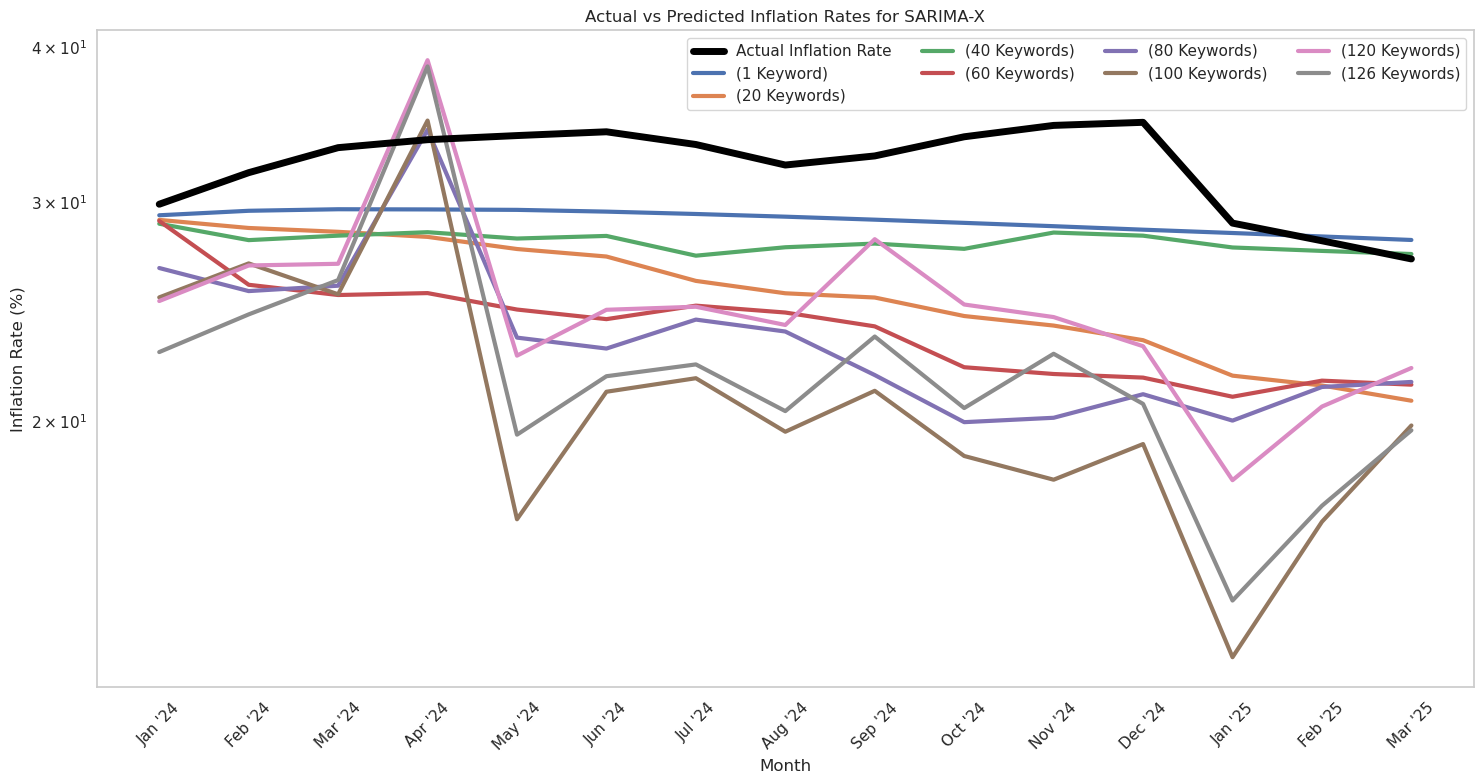

In [216]:
# Create a DataFrame for the predictions (SARIMA-X)
predictions_df_sarima = pd.DataFrame({
    'Month': test_data_no_lag['Month'].dt.strftime('%b \'%y').tolist(),
    'Actual Inflation Rate': y_test_no_lag,
    'Predicted Inflation Rate (1 Keyword)': y_pred_sarima_1_k,
    'Predicted Inflation Rate (20 Keywords)': y_pred_sarima_20_k,
    'Predicted Inflation Rate (40 Keywords)': y_pred_sarima_40_k,
    'Predicted Inflation Rate (60 Keywords)': y_pred_sarima_60_k,
    'Predicted Inflation Rate (80 Keywords)': y_pred_sarima_80_k,
    'Predicted Inflation Rate (100 Keywords)': y_pred_sarima_100_k,
    'Predicted Inflation Rate (120 Keywords)': y_pred_sarima_120_k,
    'Predicted Inflation Rate (126 Keywords)': y_pred_sarima_126_k
})
# print the first few rows of the predictions DataFrame
# display(predictions_df_sarima)
# Plot predictions for different number of features and actual inflation rate using seaborn
plt.figure(figsize=(15, 8))
# Plot actual inflation rate with highest zorder
sns.lineplot(
    data=predictions_df_sarima,
    x='Month',
    y='Actual Inflation Rate',
    label='Actual Inflation Rate',
    linewidth=5,
    color='black',
    zorder=10
)
# Plot predicted inflation rates for each number of features (no marker)
for i in [1, 20, 40, 60, 80, 100, 120, 126]:
    sns.lineplot(
        data=predictions_df_sarima,
        x='Month',
        y=f'Predicted Inflation Rate ({i} Keyword{"s" if i > 1 else ""})',
        label=f'({i} Keyword{"s" if i > 1 else ""})',
        linewidth=3,
        zorder=5
    )
plt.title('Actual vs Predicted Inflation Rates for SARIMA-X')
plt.xlabel('Month')
plt.ylabel('Inflation Rate (%)')
plt.yscale('log')
plt.xticks(rotation=45)
plt.legend(loc='best', fontsize=11, ncol=4, frameon=True, fancybox=True)
plt.grid(False)
plt.tight_layout()
plt.savefig('./actual_vs_predicted_inflation_rates_sarimax.png')
plt.show()

In [ ]:
# Using PCA to reduce dimensionality of Google Trends data

In [ ]:
# Adding the base period as feature